<a href="https://colab.research.google.com/github/dwiahmaddzul/365_ML_Process_Course/blob/main/CNN_in_Forest_Fire_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libarary Import

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Bidirectional, Dropout, InputLayer, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set random seed for reproducibility
np.random.seed(42)

## Data Acquisition

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/MY NER PROJECT/ner_karhutla.csv", encoding="latin1")
data = data.fillna(method="ffill")
data["Tag"].fillna("O", inplace=True)

data.head(20)

,Sentence,Word,Tag
0,1,Penulis:,O
1,1,Vika,B-per
2,1,Azkiya,I-per
3,1,Dihni,I-per
4,1,Editor:,I-per
5,1,Aria,B-per
6,1,W.,B-per
7,2,Yudhistira,I-per
8,2,"11/1/2022,",B-tim
9,2,10.20,I-tim


## Data Preprocessing

In [ ]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [ ]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w,  t in zip(s["Word"].values.tolist(), s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sentences = getter.sentences

word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

# Convert labels to one-hot encoding
y = [to_categorical(i, num_classes=num_tags) for i in y]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, InputLayer, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

Epoch 1/200
23/23 [==============================] - 14s 251ms/step - loss: 4.2134 - accuracy: 0.4877 - val_loss: 2.0996 - val_accuracy: 0.7036
Epoch 2/200
23/23 [==============================] - 4s 171ms/step - loss: 1.6561 - accuracy: 0.6689 - val_loss: 1.2096 - val_accuracy: 0.6939
Epoch 3/200
23/23 [==============================] - 4s 151ms/step - loss: 1.1783 - accuracy: 0.6826 - val_loss: 1.0169 - val_accuracy: 0.7097
Epoch 4/200
23/23 [==============================] - 5s 206ms/step - loss: 1.0384 - accuracy: 0.6927 - val_loss: 0.9352 - val_accuracy: 0.7368
Epoch 5/200
23/23 [==============================] - 3s 117ms/step - loss: 0.9736 - accuracy: 0.7050 - val_loss: 0.8915 - val_accuracy: 0.7468
Epoch 6/200
23/23 [==============================] - 2s 80ms/step - loss: 0.9355 - accuracy: 0.7153 - val_loss: 0.8640 - val_accuracy: 0.7475
Epoch 7/200
23/23 [==============================] - 2s 72ms/step - loss: 0.9117 - accuracy: 0.7225 - val_loss: 0.8519 - val_accuracy: 0.7524


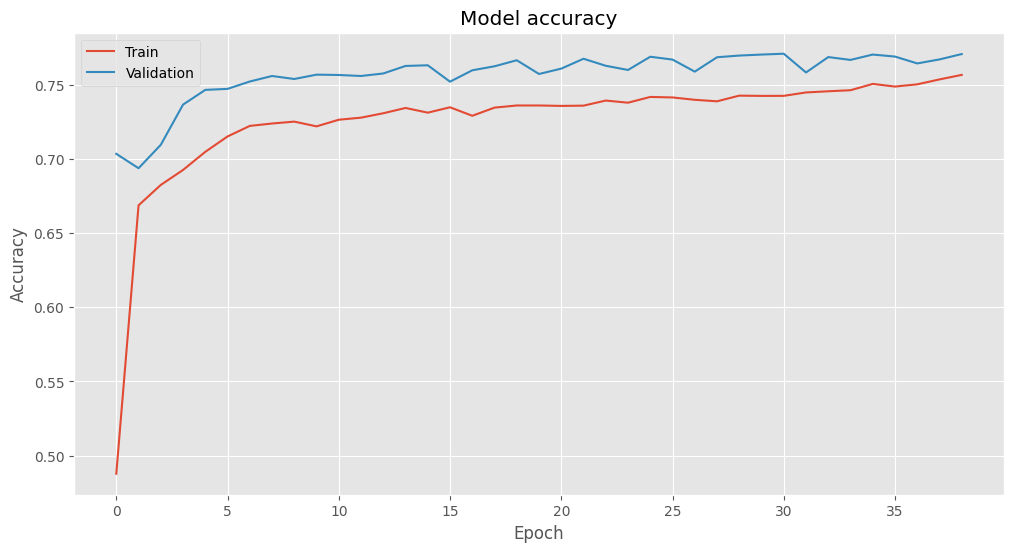

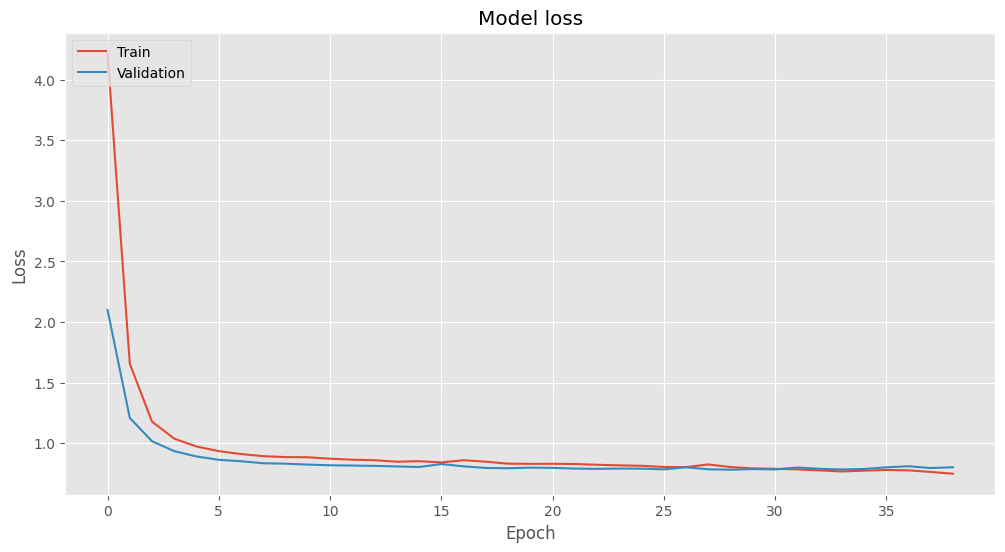

In [ ]:
# Define CNN model with regularization and dropout
cnn_model = Sequential([
    InputLayer(input_shape=(max_len,)),
    Embedding(input_dim=num_words, output_dim=128, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(max_len * num_tags, activation='softmax'),
    Reshape((max_len, num_tags))
])

# Set learning rate
learning_rate = 0.001

# Compile the model with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and time tracking
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = tf.timestamp()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(tf.timestamp() - self.epoch_time_start)

time_callback = TimeHistory()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = cnn_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2, callbacks=[time_callback, early_stopping])

# Print model summary
cnn_model.summary()

# Print time per epoch
times = time_callback.times
print(f"Average time per epoch: {np.mean(times)} seconds")

# Evaluate CNN model
cnn_eval = cnn_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"CNN Model - Loss: {cnn_eval[0]}, Accuracy: {cnn_eval[1]}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Input teks
input_text = "Hari Senin terjadi kebakaran"

# Tokenisasi teks input
input_words = input_text.split()

# Konversi kata-kata menjadi indeks numerik
input_indices = [word2idx.get(word, num_words-1) for word in input_words]

# Padding jika panjang sekuens kurang dari panjang maksimum
padded_input_indices = pad_sequences([input_indices], maxlen=max_len, padding="post", value=num_words-1)

# Melakukan prediksi dengan model CNN
predicted_tags = cnn_model.predict(padded_input_indices)

# Mengambil indeks tag dengan probabilitas tertinggi untuk setiap kata
predicted_tag_indices = np.argmax(predicted_tags, axis=-1)[0]

# Mengonversi indeks tag kembali menjadi tag teks
predicted_tags_text = [tags[idx] for idx in predicted_tag_indices]

# Menampilkan hasil
for word, tag in zip(input_words, predicted_tags_text):
    print(f"{word}: {tag}")

1/1 [==============================] - 0s 36ms/step
Hari: I-geo
Senin: O
terjadi: O
kebakaran: O


## Dilated CNN

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, InputLayer, Reshape

dilated_cnn_model = Sequential([
    InputLayer(input_shape=(max_len,)),
    Embedding(input_dim=num_words, output_dim=128, input_length=max_len),
    Conv1D(filters=128, kernel_size=3, dilation_rate=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(max_len * num_tags, activation='softmax'),
    Reshape((max_len, num_tags))
])

# Compile and train dilated CNN model similar to baseline

Epoch 1/200
23/23 [==============================] - 2s 44ms/step - loss: 1.8651 - accuracy: 0.4840 - val_loss: 0.9476 - val_accuracy: 0.6927
Epoch 2/200
23/23 [==============================] - 1s 32ms/step - loss: 1.0764 - accuracy: 0.6661 - val_loss: 0.9014 - val_accuracy: 0.7076
Epoch 3/200
23/23 [==============================] - 1s 33ms/step - loss: 0.9811 - accuracy: 0.6853 - val_loss: 0.8436 - val_accuracy: 0.7346
Epoch 4/200
23/23 [==============================] - 1s 36ms/step - loss: 0.9245 - accuracy: 0.7009 - val_loss: 0.8028 - val_accuracy: 0.7505
Epoch 5/200
23/23 [==============================] - 1s 35ms/step - loss: 0.8896 - accuracy: 0.7174 - val_loss: 0.7833 - val_accuracy: 0.7504
Epoch 6/200
23/23 [==============================] - 1s 33ms/step - loss: 0.8479 - accuracy: 0.7258 - val_loss: 0.7537 - val_accuracy: 0.7627
Epoch 7/200
23/23 [==============================] - 1s 38ms/step - loss: 0.8196 - accuracy: 0.7339 - val_loss: 0.7399 - val_accuracy: 0.7615
Epoch 

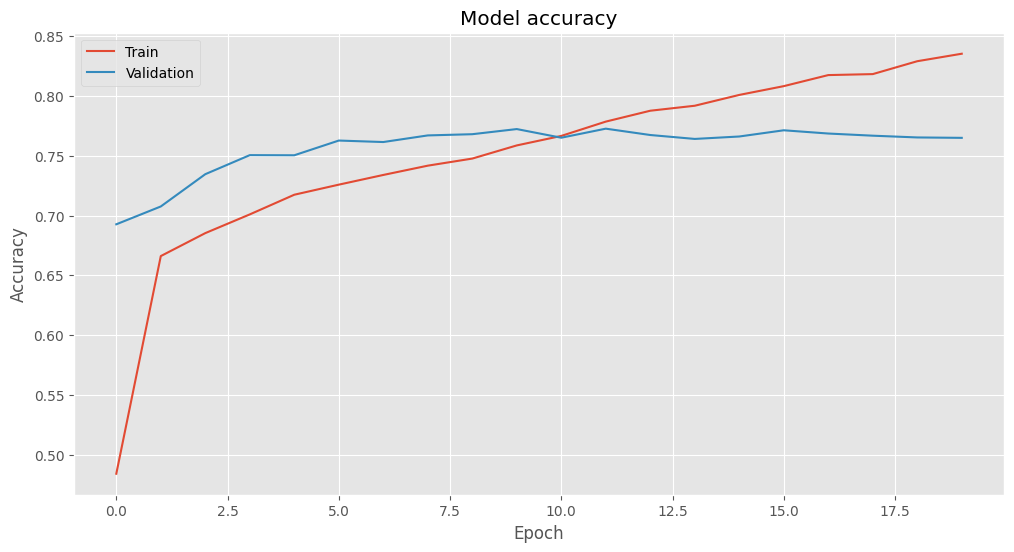

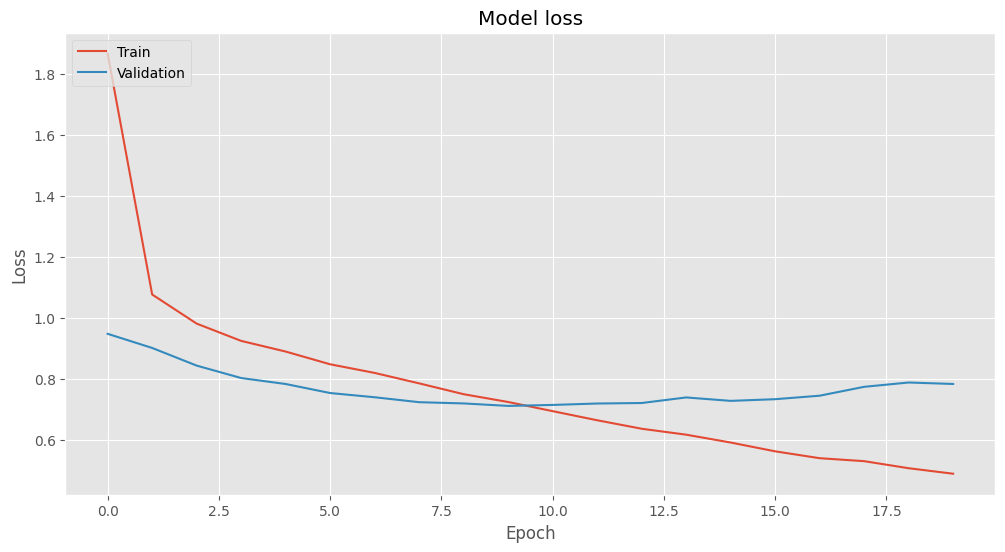

In [ ]:
# Set learning rate
learning_rate = 0.001

# Compile the model with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
dilated_cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and time tracking
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = tf.timestamp()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(tf.timestamp() - self.epoch_time_start)

time_callback = TimeHistory()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = dilated_cnn_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2, callbacks=[time_callback, early_stopping])

# Print model summary
dilated_cnn_model.summary()

# Print time per epoch
times = time_callback.times
print(f"Average time per epoch: {np.mean(times)} seconds")

# Evaluate CNN model
dilated_cnn_eval = dilated_cnn_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Dilated CNN Model - Loss: {dilated_cnn_eval[0]}, Accuracy: {dilated_cnn_eval[1]}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Residual Net

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Add, Reshape
from tensorflow.keras.models import Model  # Import Model class

Epoch 1/200
23/23 [==============================] - 4s 96ms/step - loss: 1.8296 - accuracy: 0.4645 - val_loss: 0.9458 - val_accuracy: 0.7015
Epoch 2/200
23/23 [==============================] - 2s 77ms/step - loss: 1.0504 - accuracy: 0.6825 - val_loss: 0.8516 - val_accuracy: 0.7389
Epoch 3/200
23/23 [==============================] - 2s 77ms/step - loss: 0.9295 - accuracy: 0.7110 - val_loss: 0.7846 - val_accuracy: 0.7542
Epoch 4/200
23/23 [==============================] - 1s 47ms/step - loss: 0.8492 - accuracy: 0.7299 - val_loss: 0.7479 - val_accuracy: 0.7660
Epoch 5/200
23/23 [==============================] - 1s 47ms/step - loss: 0.7980 - accuracy: 0.7389 - val_loss: 0.7386 - val_accuracy: 0.7653
Epoch 6/200
23/23 [==============================] - 1s 47ms/step - loss: 0.7456 - accuracy: 0.7512 - val_loss: 0.7297 - val_accuracy: 0.7740
Epoch 7/200
23/23 [==============================] - 1s 46ms/step - loss: 0.7046 - accuracy: 0.7642 - val_loss: 0.7361 - val_accuracy: 0.7690
Epoch 

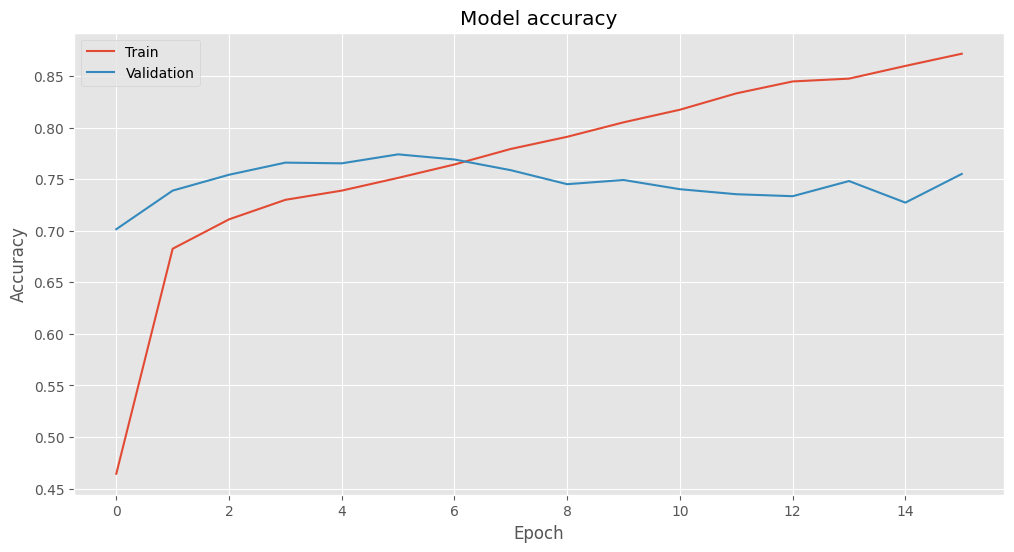

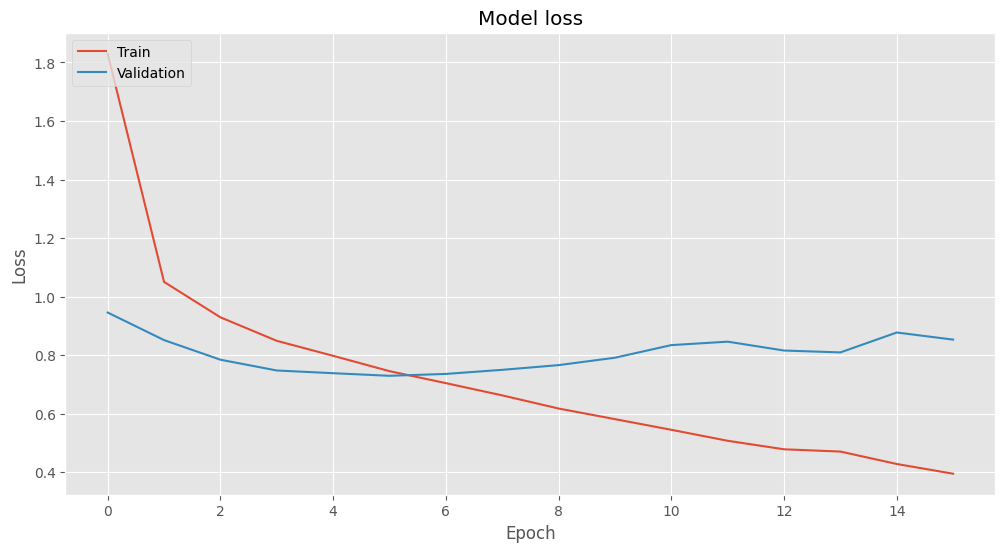

In [ ]:
from tensorflow.keras.layers import Add

# Define Residual Block
def residual_block(x, filters, kernel_size=3):
    conv = Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    conv = Conv1D(filters, kernel_size, padding='same')(conv)
    x = Add()([x, conv])
    return x

# Input Layer
inputs = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(inputs)

# Residual Block
model = residual_block(model, filters=128)
model = MaxPooling1D(pool_size=2)(model)

# Fully Connected Layer
model = Flatten()(model)
model = Dense(128, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(max_len * num_tags, activation='softmax')(model)
outputs = Reshape((max_len, num_tags))(model)

# Define the model
residual_cnn_model = Model(inputs, outputs)

# Compile the model
residual_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and time tracking
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = tf.timestamp()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(tf.timestamp() - self.epoch_time_start)

time_callback = TimeHistory()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = residual_cnn_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2, callbacks=[time_callback, early_stopping])

# Print model summary
residual_cnn_model.summary()

# Print time per epoch
times = time_callback.times
print(f"Average time per epoch: {np.mean(times)} seconds")

# Evaluate CNN model
residual_cnn_eval = residual_cnn_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Residual CNN Model - Loss: {residual_cnn_eval[0]}, Accuracy: {residual_cnn_eval[1]}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Attention CNN

Ver 1

Epoch 1/200
23/23 [==============================] - 5s 123ms/step - loss: 1.9612 - accuracy: 0.4319 - val_loss: 1.0063 - val_accuracy: 0.6949
Epoch 2/200
23/23 [==============================] - 3s 145ms/step - loss: 1.1343 - accuracy: 0.6654 - val_loss: 0.9536 - val_accuracy: 0.6997
Epoch 3/200
23/23 [==============================] - 3s 124ms/step - loss: 1.0451 - accuracy: 0.6715 - val_loss: 0.9206 - val_accuracy: 0.7011
Epoch 4/200
23/23 [==============================] - 2s 93ms/step - loss: 0.9912 - accuracy: 0.6822 - val_loss: 0.8726 - val_accuracy: 0.7209
Epoch 5/200
23/23 [==============================] - 2s 83ms/step - loss: 0.9470 - accuracy: 0.6911 - val_loss: 0.8506 - val_accuracy: 0.7320
Epoch 6/200
23/23 [==============================] - 2s 79ms/step - loss: 0.9118 - accuracy: 0.7013 - val_loss: 0.8140 - val_accuracy: 0.7506
Epoch 7/200
23/23 [==============================] - 2s 82ms/step - loss: 0.8770 - accuracy: 0.7127 - val_loss: 0.8076 - val_accuracy: 0.7557
Epo

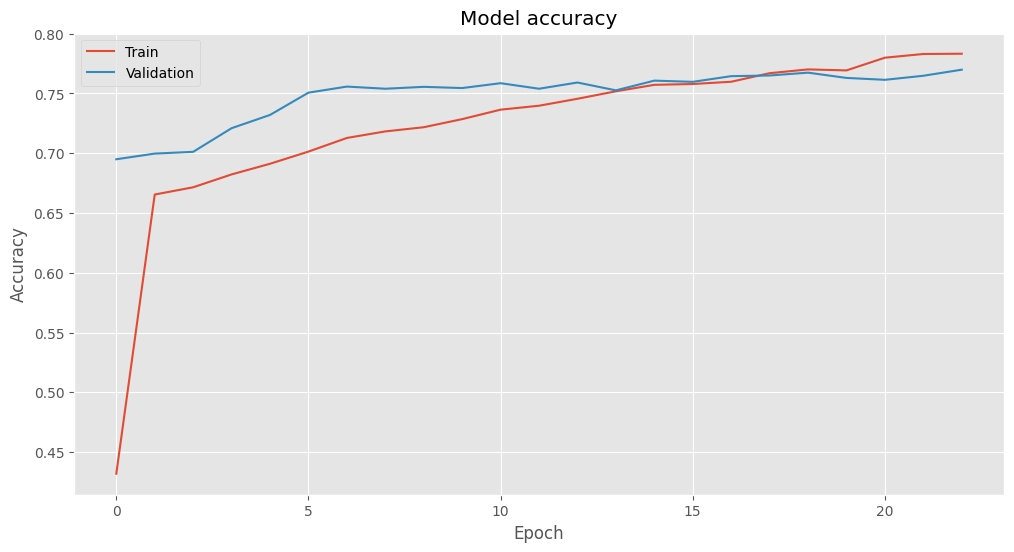

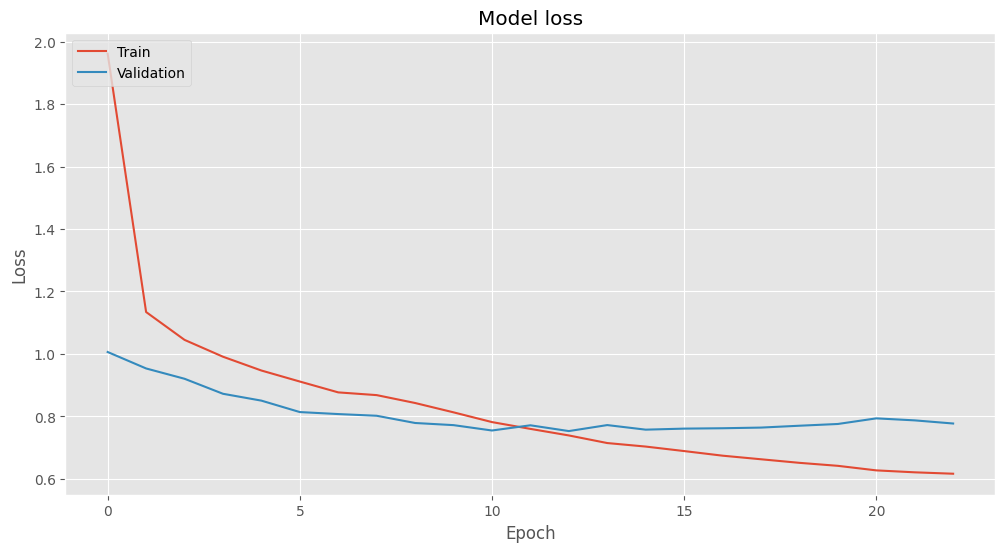

In [ ]:
from tensorflow.keras.layers import Attention

# Define Attention Block
def attention_block(x):
    attention = Attention()([x, x])
    return attention

# Input Layer
inputs = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(inputs)

# Convolutional Layer
model = Conv1D(filters=128, kernel_size=3, activation='relu')(model)
model = MaxPooling1D(pool_size=2)(model)

# Attention Block
model = attention_block(model)

# Fully Connected Layer
model = Flatten()(model)
model = Dense(128, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(max_len * num_tags, activation='softmax')(model)
outputs = Reshape((max_len, num_tags))(model)

# Define the model
attention_cnn_model = Model(inputs, outputs)

# Compile the model
attention_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and time tracking
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = tf.timestamp()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(tf.timestamp() - self.epoch_time_start)

time_callback = TimeHistory()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = attention_cnn_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2, callbacks=[time_callback, early_stopping])

# Print model summary
attention_cnn_model.summary()

# Print time per epoch
times = time_callback.times
print(f"Average time per epoch: {np.mean(times)} seconds")

# Evaluate CNN model
attention_cnn_eval = attention_cnn_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Attention CNN Model - Loss: {attention_cnn_eval[0]}, Accuracy: {attention_cnn_eval[1]}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

ver 2

Epoch 1/200
23/23 [==============================] - 9s 135ms/step - loss: 2.0863 - accuracy: 0.4855 - val_loss: 1.1210 - val_accuracy: 0.7011
Epoch 2/200
23/23 [==============================] - 1s 55ms/step - loss: 1.1278 - accuracy: 0.6640 - val_loss: 0.9535 - val_accuracy: 0.6897
Epoch 3/200
23/23 [==============================] - 1s 55ms/step - loss: 1.0301 - accuracy: 0.6716 - val_loss: 0.9328 - val_accuracy: 0.6997
Epoch 4/200
23/23 [==============================] - 1s 48ms/step - loss: 1.0024 - accuracy: 0.6774 - val_loss: 0.9245 - val_accuracy: 0.7007
Epoch 5/200
23/23 [==============================] - 1s 39ms/step - loss: 0.9789 - accuracy: 0.6793 - val_loss: 0.8983 - val_accuracy: 0.7067
Epoch 6/200
23/23 [==============================] - 1s 47ms/step - loss: 0.9281 - accuracy: 0.6896 - val_loss: 0.8617 - val_accuracy: 0.7241
Epoch 7/200
23/23 [==============================] - 1s 56ms/step - loss: 0.8904 - accuracy: 0.7004 - val_loss: 0.8291 - val_accuracy: 0.7429
Epoch

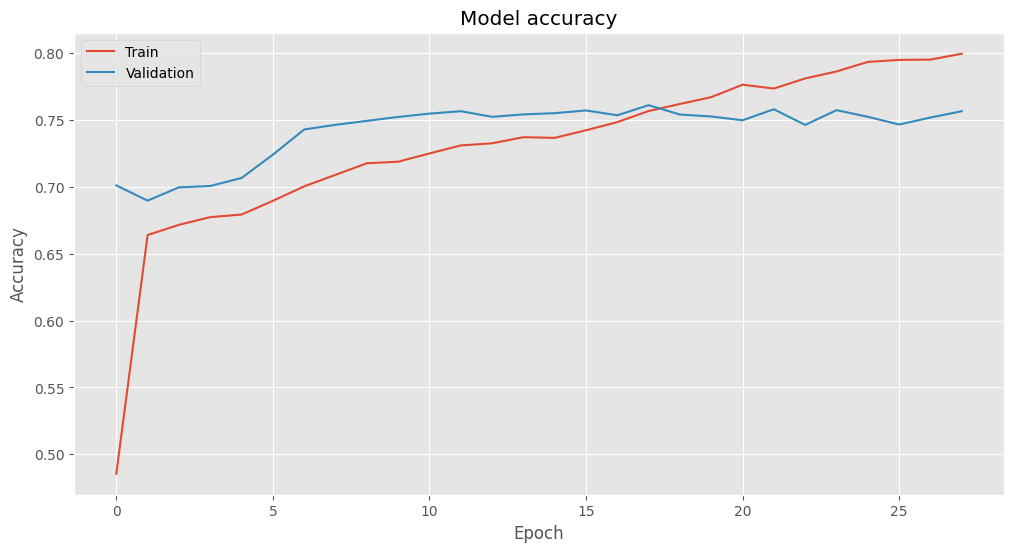

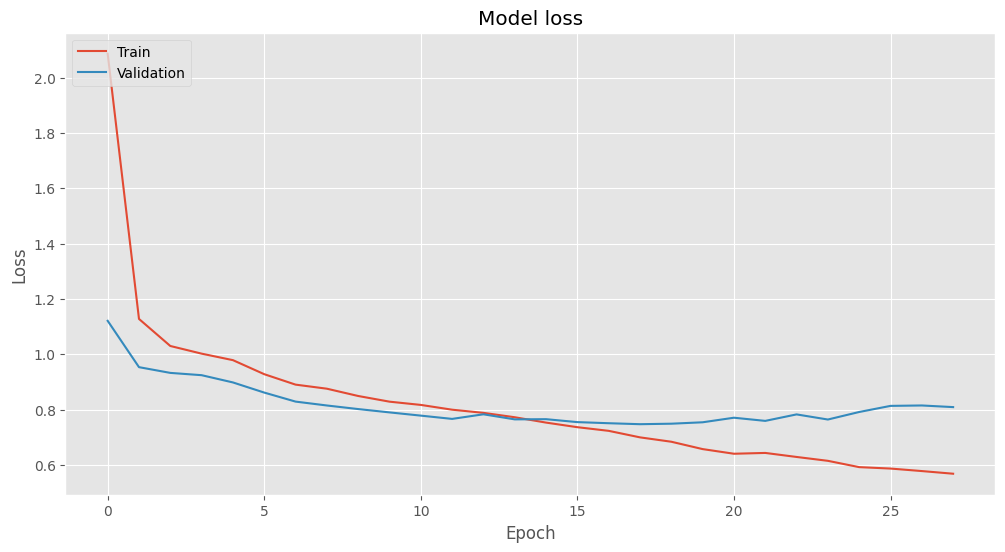

In [ ]:
from tensorflow.keras.layers import Attention

# Define Attention Block
def attention_block(x):
    attention = Attention()([x, x])
    return attention

# Input Layer
inputs = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(inputs)

# Convolutional Layers with Attention
model = Conv1D(filters=32, kernel_size=3, activation='relu')(model)
model = attention_block(model)
model = MaxPooling1D(pool_size=2)(model)

model = Conv1D(filters=64, kernel_size=5, activation='relu')(model)
model = attention_block(model)
model = MaxPooling1D(pool_size=2)(model)

# Attention Block
model = attention_block(model)

# Fully Connected Layer
model = Flatten()(model)
model = Dense(128, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(max_len * num_tags, activation='softmax')(model)
outputs = Reshape((max_len, num_tags))(model)

# Define the model
attention_cnn_model = Model(inputs, outputs)

# Compile the model
attention_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and time tracking
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = tf.timestamp()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(tf.timestamp() - self.epoch_time_start)

time_callback = TimeHistory()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = attention_cnn_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2, callbacks=[time_callback, early_stopping])

# Print model summary
attention_cnn_model.summary()

# Print time per epoch
times = time_callback.times
print(f"Average time per epoch: {np.mean(times)} seconds")

# Evaluate CNN model
attention_cnn_eval = attention_cnn_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Attention CNN Model - Loss: {attention_cnn_eval[0]}, Accuracy: {attention_cnn_eval[1]}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Inception CNN

ver 1

Epoch 1/200
23/23 [==============================] - 3s 59ms/step - loss: 1.7736 - accuracy: 0.4840 - val_loss: 0.9507 - val_accuracy: 0.7035
Epoch 2/200
23/23 [==============================] - 1s 49ms/step - loss: 1.0556 - accuracy: 0.6784 - val_loss: 0.8850 - val_accuracy: 0.7226
Epoch 3/200
23/23 [==============================] - 2s 83ms/step - loss: 0.9627 - accuracy: 0.6970 - val_loss: 0.8219 - val_accuracy: 0.7423
Epoch 4/200
23/23 [==============================] - 3s 126ms/step - loss: 0.9021 - accuracy: 0.7148 - val_loss: 0.7882 - val_accuracy: 0.7501
Epoch 5/200
23/23 [==============================] - 3s 141ms/step - loss: 0.8676 - accuracy: 0.7176 - val_loss: 0.7610 - val_accuracy: 0.7560
Epoch 6/200
23/23 [==============================] - 2s 97ms/step - loss: 0.8343 - accuracy: 0.7260 - val_loss: 0.7529 - val_accuracy: 0.7571
Epoch 7/200
23/23 [==============================] - 2s 92ms/step - loss: 0.8002 - accuracy: 0.7314 - val_loss: 0.7317 - val_accuracy: 0.7643
Epoc

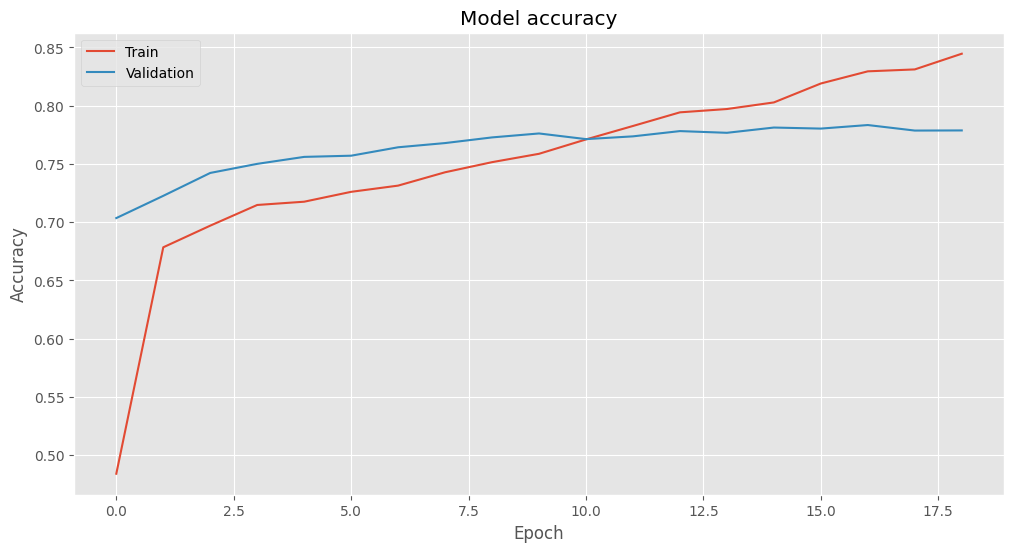

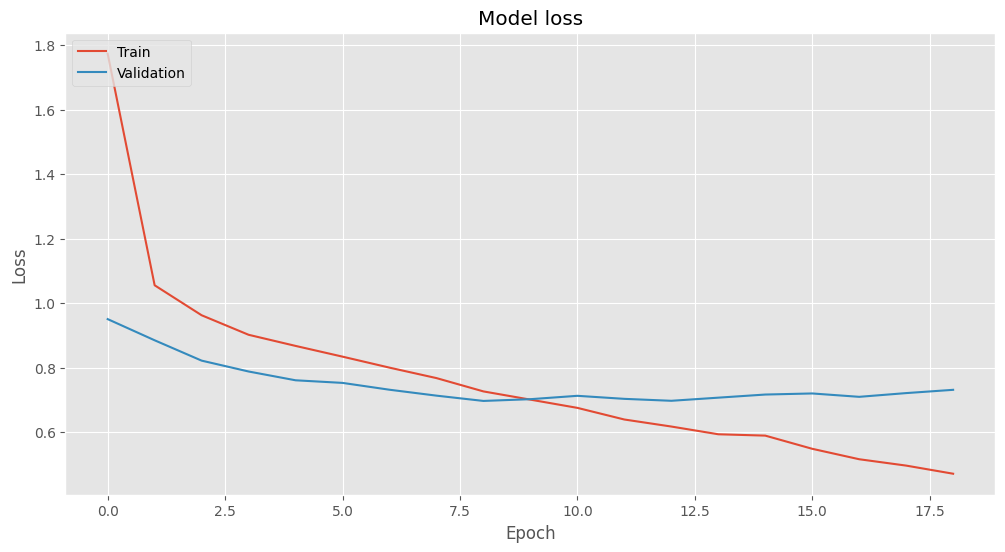

In [ ]:
from tensorflow.keras.layers import concatenate

# Define Inception Block
def inception_block(x, filters):
    conv1 = Conv1D(filters, kernel_size=1, activation='relu', padding='same')(x)
    conv3 = Conv1D(filters, kernel_size=3, activation='relu', padding='same')(x)
    conv5 = Conv1D(filters, kernel_size=5, activation='relu', padding='same')(x)
    pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
    return concatenate([conv1, conv3, conv5, pool], axis=-1)

# Input Layer
inputs = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(inputs)

# Inception Block
model = inception_block(model, filters=32)
model = MaxPooling1D(pool_size=2)(model)

# Fully Connected Layer
model = Flatten()(model)
model = Dense(128, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(max_len * num_tags, activation='softmax')(model)
outputs = Reshape((max_len, num_tags))(model)

# Define the model
inception_cnn_model = Model(inputs, outputs)

# Compile the model
inception_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and time tracking
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = tf.timestamp()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(tf.timestamp() - self.epoch_time_start)

time_callback = TimeHistory()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = inception_cnn_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2, callbacks=[time_callback, early_stopping])

# Print model summary
inception_cnn_model.summary()

# Print time per epoch
times = time_callback.times
print(f"Average time per epoch: {np.mean(times)} seconds")

# Evaluate CNN model
inception_cnn_eval = inception_cnn_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"inception CNN Model - Loss: {inception_cnn_eval[0]}, Accuracy: {inception_cnn_eval[1]}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

ver 2

Epoch 1/200
23/23 [==============================] - 11s 97ms/step - loss: 1.9390 - accuracy: 0.4471 - val_loss: 1.0032 - val_accuracy: 0.6963
Epoch 2/200
23/23 [==============================] - 2s 82ms/step - loss: 1.0831 - accuracy: 0.6717 - val_loss: 0.9268 - val_accuracy: 0.7056
Epoch 3/200
23/23 [==============================] - 2s 80ms/step - loss: 0.9941 - accuracy: 0.6813 - val_loss: 0.8631 - val_accuracy: 0.7258
Epoch 4/200
23/23 [==============================] - 2s 95ms/step - loss: 0.9321 - accuracy: 0.7033 - val_loss: 0.8087 - val_accuracy: 0.7451
Epoch 5/200
23/23 [==============================] - 2s 86ms/step - loss: 0.8784 - accuracy: 0.7178 - val_loss: 0.7642 - val_accuracy: 0.7592
Epoch 6/200
23/23 [==============================] - 2s 97ms/step - loss: 0.8377 - accuracy: 0.7296 - val_loss: 0.7490 - val_accuracy: 0.7646
Epoch 7/200
23/23 [==============================] - 2s 73ms/step - loss: 0.7920 - accuracy: 0.7356 - val_loss: 0.7255 - val_accuracy: 0.7686
Epoch

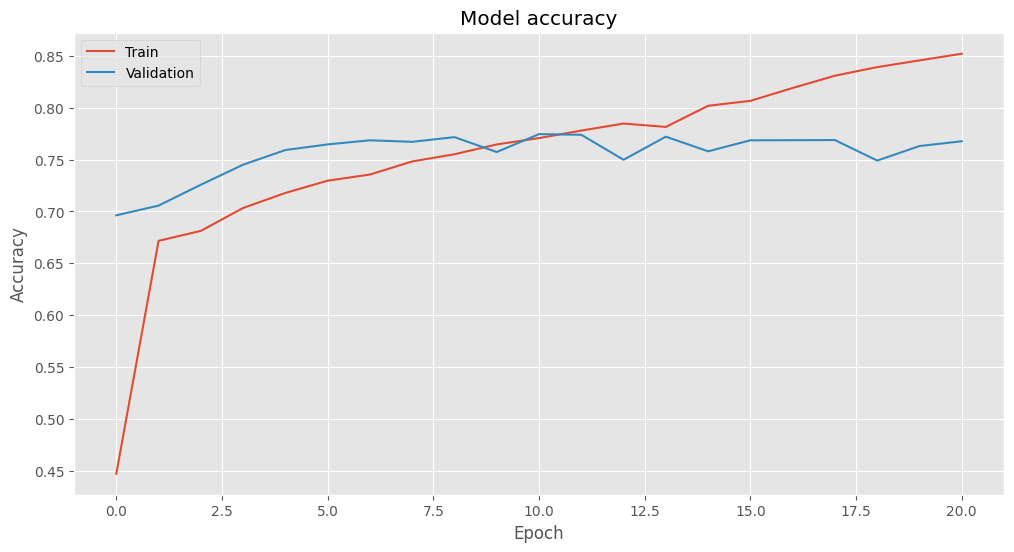

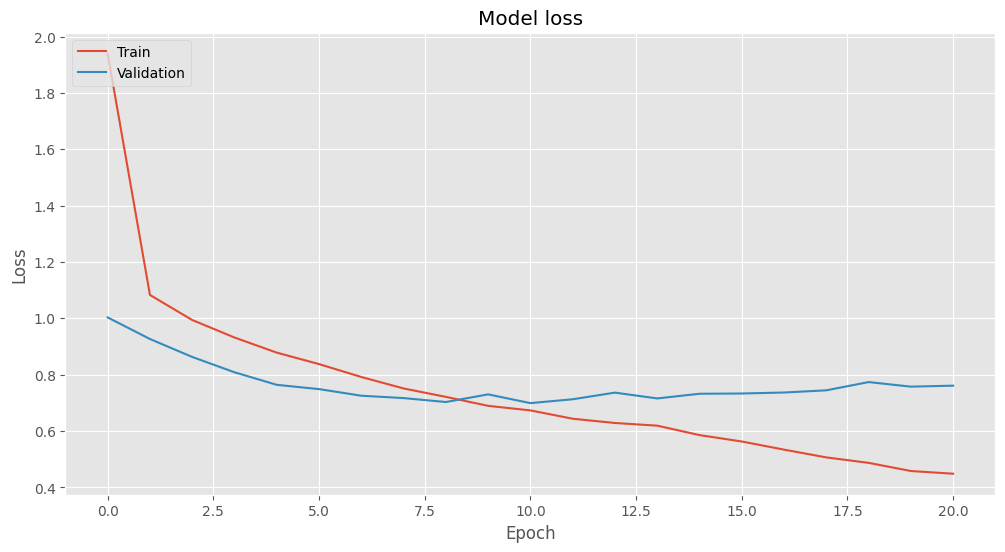

In [ ]:
from tensorflow.keras.layers import concatenate, Conv1D, MaxPooling1D

# Define Inception Block
def inception_block(x, filters):
  # Branch 1: 1x1 convolution
  conv1 = Conv1D(filters // 4, kernel_size=1, activation='relu', padding='same')(x)

  # Branch 2: 3x3 convolution
  conv3 = Conv1D(filters // 4, kernel_size=3, activation='relu', padding='same')(x)

  # Branch 3: 5x5 convolution
  conv5 = Conv1D(filters // 4, kernel_size=5, activation='relu', padding='same')(x)

  # Branch 4: Max pooling
  pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
  pool = Conv1D(filters // 4, kernel_size=1, activation='relu', padding='same')(pool)

  # Concatenate outputs
  return concatenate([conv1, conv3, conv5, pool], axis=-1)

# Input Layer
inputs = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(inputs)

# Stacked Inception Blocks (modify number of blocks and filters)
model = inception_block(model, filters=32)  # Initial block with fewer filters
model = MaxPooling1D(pool_size=2)(model)
model = inception_block(model, filters=64)  # Increase filters in subsequent blocks
model = MaxPooling1D(pool_size=2)(model)
model = inception_block(model, filters=128)  # You can add more Inception blocks

# Fully Connected Layer
model = Flatten()(model)
model = Dense(128, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(max_len * num_tags, activation='softmax')(model)
outputs = Reshape((max_len, num_tags))(model)

# Define the model
inception_cnn_model = Model(inputs, outputs)

# Compile the model (rest remains the same)
inception_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and time tracking
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = tf.timestamp()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(tf.timestamp() - self.epoch_time_start)

time_callback = TimeHistory()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = inception_cnn_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2, callbacks=[time_callback, early_stopping])

# Print model summary
inception_cnn_model.summary()

# Print time per epoch
times = time_callback.times
print(f"Average time per epoch: {np.mean(times)} seconds")

# Evaluate CNN model
inception_cnn_eval = inception_cnn_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"inception CNN Model - Loss: {inception_cnn_eval[0]}, Accuracy: {inception_cnn_eval[1]}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Depthwise Separable Convulutions

Epoch 1/200
23/23 [==============================] - 3s 45ms/step - loss: 2.2531 - accuracy: 0.4876 - val_loss: 1.0952 - val_accuracy: 0.6988
Epoch 2/200
23/23 [==============================] - 1s 30ms/step - loss: 1.1946 - accuracy: 0.6670 - val_loss: 0.9891 - val_accuracy: 0.6999
Epoch 3/200
23/23 [==============================] - 1s 30ms/step - loss: 1.0442 - accuracy: 0.6725 - val_loss: 0.9336 - val_accuracy: 0.7046
Epoch 4/200
23/23 [==============================] - 1s 29ms/step - loss: 0.9952 - accuracy: 0.6786 - val_loss: 0.9052 - val_accuracy: 0.7031
Epoch 5/200
23/23 [==============================] - 1s 30ms/step - loss: 0.9571 - accuracy: 0.6826 - val_loss: 0.8697 - val_accuracy: 0.7232
Epoch 6/200
23/23 [==============================] - 1s 29ms/step - loss: 0.9288 - accuracy: 0.6973 - val_loss: 0.8365 - val_accuracy: 0.7307
Epoch 7/200
23/23 [==============================] - 1s 42ms/step - loss: 0.8913 - accuracy: 0.7022 - val_loss: 0.7958 - val_accuracy: 0.7547
Epoch 

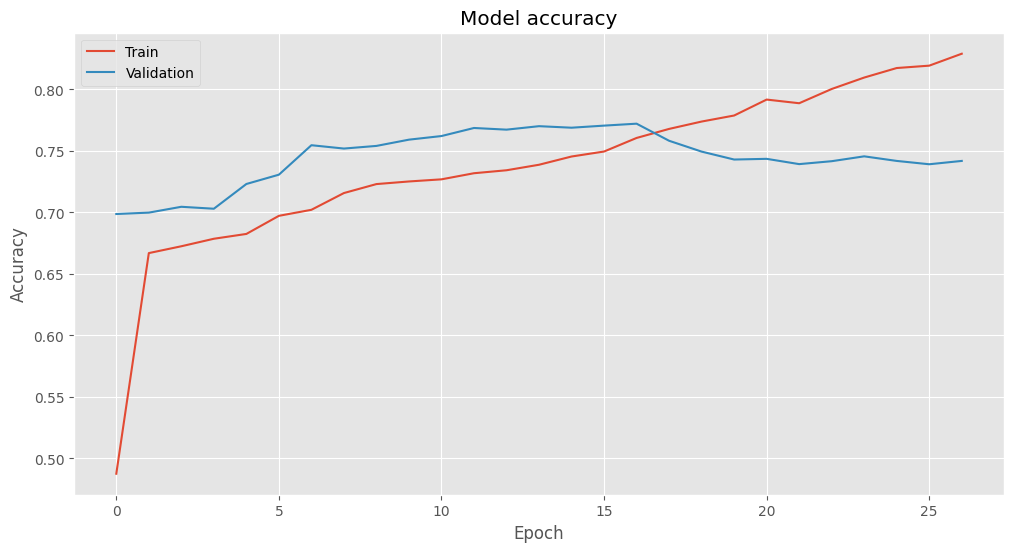

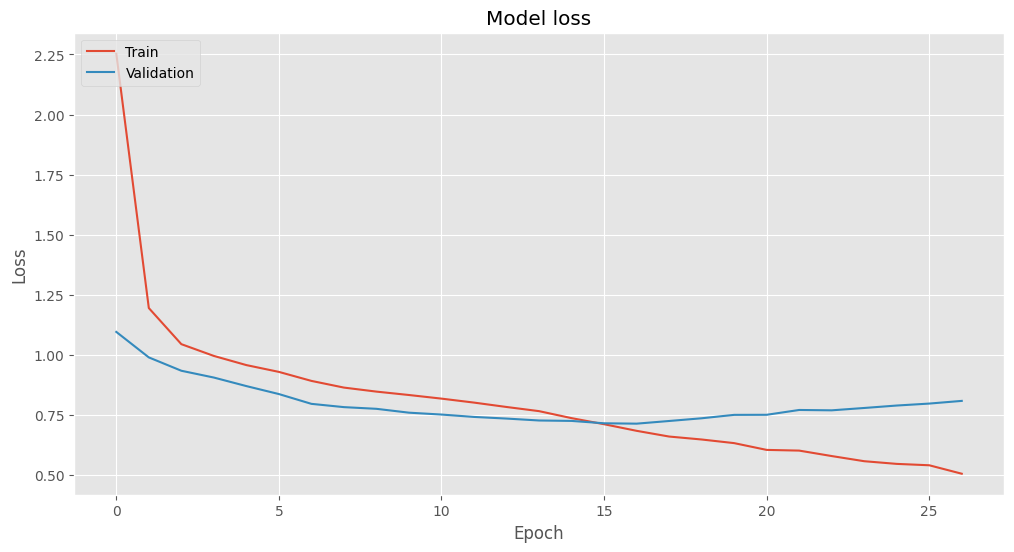

In [ ]:
from tensorflow.keras.layers import SeparableConv1D

# Define Depthwise Separable Convolutional Block
def depthwise_separable_conv_block(x, filters):
    return SeparableConv1D(filters, kernel_size=3, padding='same', activation='relu')(x)

# Input Layer
inputs = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(inputs)

# Depthwise Separable Convolutional Block
model = depthwise_separable_conv_block(model, filters=128)
model = MaxPooling1D(pool_size=2)(model)

# Fully Connected Layer
model = Flatten()(model)
model = Dense(128, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(max_len * num_tags, activation='softmax')(model)
outputs = Reshape((max_len, num_tags))(model)

# Define the model
depthwise_separable_cnn_model = Model(inputs, outputs)

# Compile the model
depthwise_separable_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and time tracking
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = tf.timestamp()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(tf.timestamp() - self.epoch_time_start)

time_callback = TimeHistory()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = depthwise_separable_cnn_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2, callbacks=[time_callback, early_stopping])

# Print model summary
depthwise_separable_cnn_model.summary()

# Print time per epoch
times = time_callback.times
print(f"Average time per epoch: {np.mean(times)} seconds")

# Evaluate CNN model
depthwise_separable_cnn_eval = depthwise_separable_cnn_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"depthwise_separable CNN Model - Loss: {depthwise_separable_cnn_eval[0]}, Accuracy: {depthwise_separable_cnn_eval[1]}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

ver 2

Epoch 1/200
23/23 [==============================] - 4s 73ms/step - loss: 2.5657 - accuracy: 0.5446 - val_loss: 2.2645 - val_accuracy: 0.6528
Epoch 2/200
23/23 [==============================] - 1s 57ms/step - loss: 1.5959 - accuracy: 0.6586 - val_loss: 1.1161 - val_accuracy: 0.7011
Epoch 3/200
23/23 [==============================] - 1s 45ms/step - loss: 1.1855 - accuracy: 0.6782 - val_loss: 1.0502 - val_accuracy: 0.7011
Epoch 4/200
23/23 [==============================] - 1s 35ms/step - loss: 1.1296 - accuracy: 0.6764 - val_loss: 1.0383 - val_accuracy: 0.6997
Epoch 5/200
23/23 [==============================] - 1s 31ms/step - loss: 1.1237 - accuracy: 0.6796 - val_loss: 1.0362 - val_accuracy: 0.7011
Epoch 6/200
23/23 [==============================] - 1s 46ms/step - loss: 1.1179 - accuracy: 0.6796 - val_loss: 1.0360 - val_accuracy: 0.7011
Epoch 7/200
23/23 [==============================] - 1s 47ms/step - loss: 1.1126 - accuracy: 0.6799 - val_loss: 1.0352 - val_accuracy: 0.7011
Epoch 

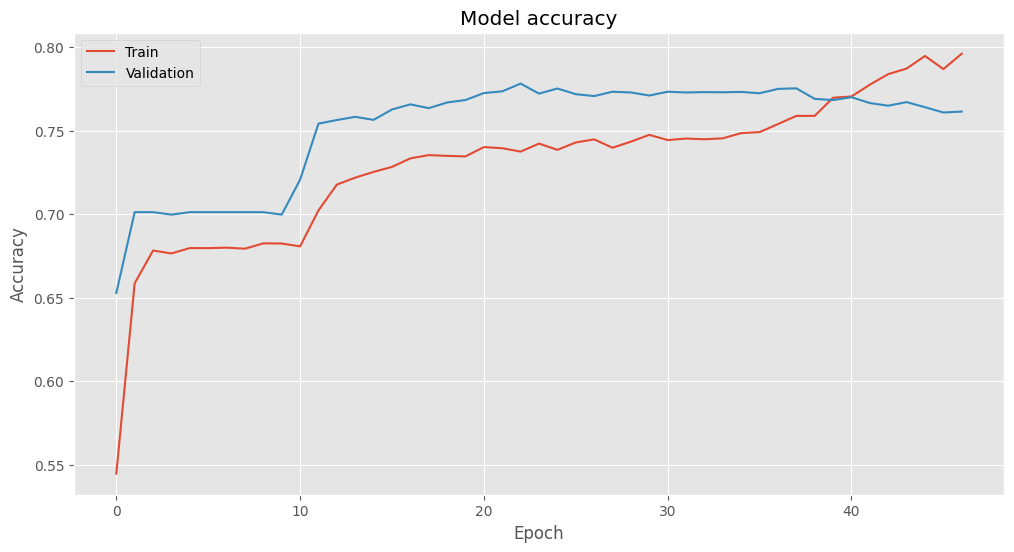

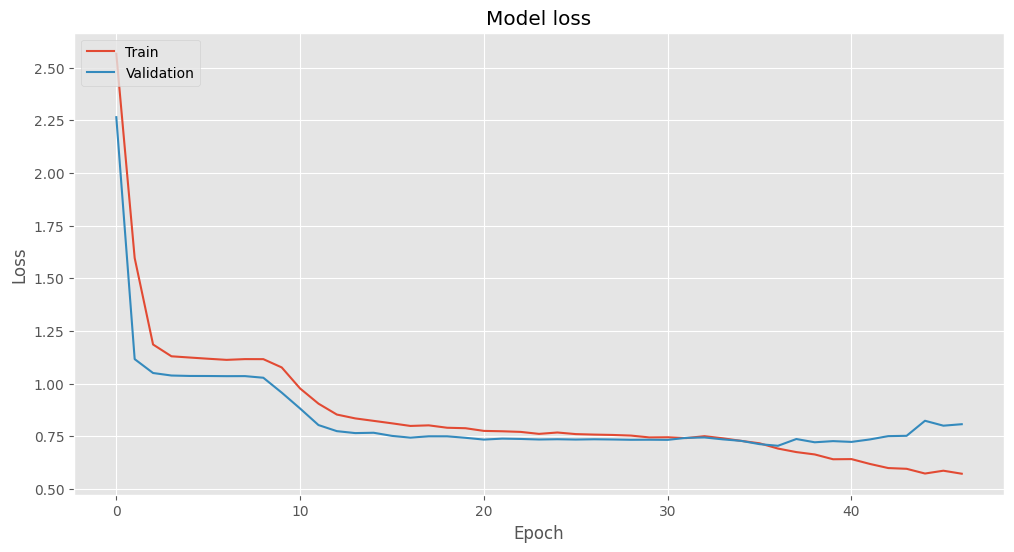

In [ ]:
from tensorflow.keras.layers import SeparableConv1D, MaxPooling1D

# Define Depthwise Separable Convolutional Block
def depthwise_separable_conv_block(x, filters):
  # Depthwise convolution with ReLU activation
  x = SeparableConv1D(filters, kernel_size=3, padding='same', depth_multiplier=1, activation='relu')(x)
  # Pointwise convolution with ReLU activation
  x = SeparableConv1D(filters, kernel_size=1, padding='same', activation='relu')(x)
  return x

# Input Layer
inputs = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(inputs)

# Stacked Depthwise Separable Blocks (modify number of blocks and filters)
model = depthwise_separable_conv_block(model, filters=32)
model = MaxPooling1D(pool_size=2)(model)
model = depthwise_separable_conv_block(model, filters=64)  # Increase filters in subsequent blocks
model = MaxPooling1D(pool_size=2)(model)
model = depthwise_separable_conv_block(model, filters=128)  # You can add more blocks

# Fully Connected Layer
model = Flatten()(model)
model = Dense(128, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(max_len * num_tags, activation='softmax')(model)
outputs = Reshape((max_len, num_tags))(model)

# Define the model
depthwise_separable_cnn_model = Model(inputs, outputs)

# Compile the model (rest remains the same)
depthwise_separable_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and time tracking
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = tf.timestamp()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(tf.timestamp() - self.epoch_time_start)

time_callback = TimeHistory()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = depthwise_separable_cnn_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2, callbacks=[time_callback, early_stopping])

# Print model summary
depthwise_separable_cnn_model.summary()

# Print time per epoch
times = time_callback.times
print(f"Average time per epoch: {np.mean(times)} seconds")

# Evaluate CNN model
depthwise_separable_cnn_eval = depthwise_separable_cnn_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"depthwise_separable CNN Model - Loss: {depthwise_separable_cnn_eval[0]}, Accuracy: {depthwise_separable_cnn_eval[1]}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Hybrid experimental

Epoch 1/200
23/23 [==============================] - 10s 65ms/step - loss: 2.5407 - accuracy: 0.5650 - val_loss: 2.1155 - val_accuracy: 0.6893
Epoch 2/200
23/23 [==============================] - 1s 44ms/step - loss: 1.4563 - accuracy: 0.6751 - val_loss: 1.0919 - val_accuracy: 0.7011
Epoch 3/200
23/23 [==============================] - 1s 41ms/step - loss: 1.1489 - accuracy: 0.6719 - val_loss: 1.0262 - val_accuracy: 0.7011
Epoch 4/200
23/23 [==============================] - 1s 40ms/step - loss: 1.1033 - accuracy: 0.6757 - val_loss: 0.9864 - val_accuracy: 0.7003
Epoch 5/200
23/23 [==============================] - 1s 59ms/step - loss: 1.0359 - accuracy: 0.6795 - val_loss: 0.9340 - val_accuracy: 0.6997
Epoch 6/200
23/23 [==============================] - 2s 71ms/step - loss: 0.9765 - accuracy: 0.6802 - val_loss: 0.8725 - val_accuracy: 0.7253
Epoch 7/200
23/23 [==============================] - 2s 74ms/step - loss: 0.9132 - accuracy: 0.7030 - val_loss: 0.8086 - val_accuracy: 0.7489
Epoch

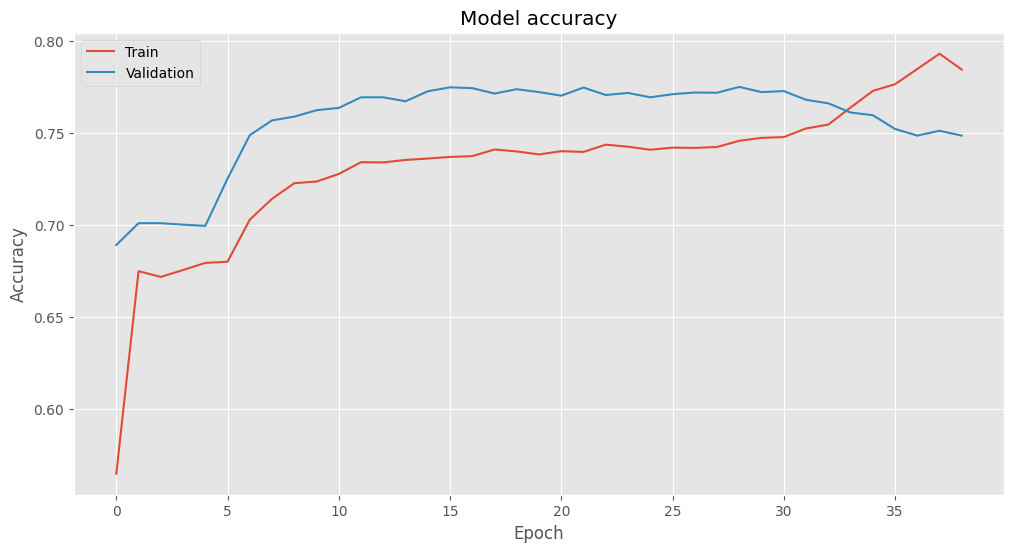

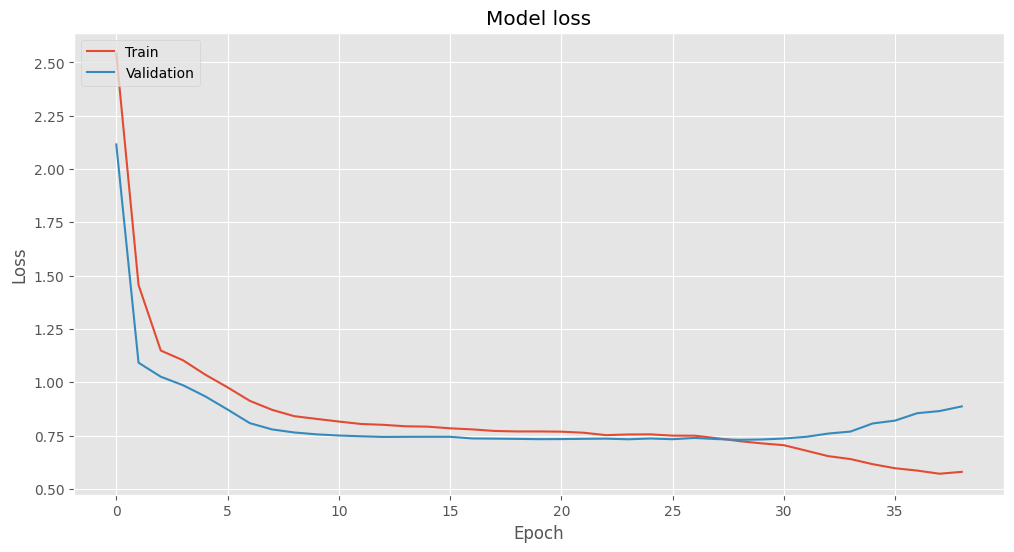

In [ ]:
from tensorflow.keras.layers import SeparableConv1D, MaxPooling1D, concatenate

# Define Inception-based Depthwise Separable Convolutional Block
def inception_depthwise_separable_conv_block(x, filters):
  # Branch 1: 1x1 depthwise convolution
  conv1 = SeparableConv1D(filters // 4, kernel_size=1, padding='same', depth_multiplier=1, activation='relu')(x)

  # Branch 2: 3x3 depthwise convolution
  conv3 = SeparableConv1D(filters // 4, kernel_size=3, padding='same', depth_multiplier=1, activation='relu')(x)

  # Branch 3: 5x5 depthwise convolution
  conv5 = SeparableConv1D(filters // 4, kernel_size=5, padding='same', depth_multiplier=1, activation='relu')(x)

  # Branch 4: Max pooling
  pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
  pool = SeparableConv1D(filters // 4, kernel_size=1, padding='same', depth_multiplier=1, activation='relu')(pool)

  # Concatenate outputs
  return concatenate([conv1, conv3, conv5, pool], axis=-1)

# Input Layer
inputs = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(inputs)

# Stacked Inception-based Depthwise Separable Blocks (modify number of blocks and filters)
model = inception_depthwise_separable_conv_block(model, filters=32)  # Initial block with fewer filters
model = MaxPooling1D(pool_size=2)(model)
model = inception_depthwise_separable_conv_block(model, filters=64)  # Increase filters in subsequent blocks
model = MaxPooling1D(pool_size=2)(model)
model = inception_depthwise_separable_conv_block(model, filters=128)  # You can add more blocks

# Fully Connected Layer
model = Flatten()(model)
model = Dense(128, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(max_len * num_tags, activation='softmax')(model)
outputs = Reshape((max_len, num_tags))(model)

# Define the model
inception_inception_depthwise_separable_cnn_model_model = Model(inputs, outputs)

# Compile the model (rest remains the same)
inception_inception_depthwise_separable_cnn_model_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and time tracking
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = tf.timestamp()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(tf.timestamp() - self.epoch_time_start)

time_callback = TimeHistory()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = inception_inception_depthwise_separable_cnn_model_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2, callbacks=[time_callback, early_stopping])

# Print model summary
inception_inception_depthwise_separable_cnn_model_model.summary()

# Print time per epoch
times = time_callback.times
print(f"Average time per epoch: {np.mean(times)} seconds")

# Evaluate CNN model
inception_depthwise_separable_cnn_model_eval = inception_inception_depthwise_separable_cnn_model_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"depthwise_separable CNN Model - Loss: {inception_depthwise_separable_cnn_model_eval[0]}, Accuracy: {inception_depthwise_separable_cnn_model_eval[1]}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Temporal CN

ver 1

Epoch 1/200
23/23 [==============================] - 8s 151ms/step - loss: 1.8892 - accuracy: 0.4192 - val_loss: 0.9427 - val_accuracy: 0.7156
Epoch 2/200
23/23 [==============================] - 2s 106ms/step - loss: 1.0431 - accuracy: 0.6902 - val_loss: 0.8181 - val_accuracy: 0.7487
Epoch 3/200
23/23 [==============================] - 3s 153ms/step - loss: 0.8820 - accuracy: 0.7278 - val_loss: 0.7837 - val_accuracy: 0.7554
Epoch 4/200
23/23 [==============================] - 4s 164ms/step - loss: 0.7710 - accuracy: 0.7540 - val_loss: 0.7598 - val_accuracy: 0.7609
Epoch 5/200
23/23 [==============================] - 4s 182ms/step - loss: 0.6667 - accuracy: 0.7876 - val_loss: 0.7640 - val_accuracy: 0.7611
Epoch 6/200
23/23 [==============================] - 4s 161ms/step - loss: 0.5718 - accuracy: 0.8181 - val_loss: 0.7601 - val_accuracy: 0.7583
Epoch 7/200
23/23 [==============================] - 2s 104ms/step - loss: 0.5013 - accuracy: 0.8433 - val_loss: 0.7562 - val_accuracy: 0.7603

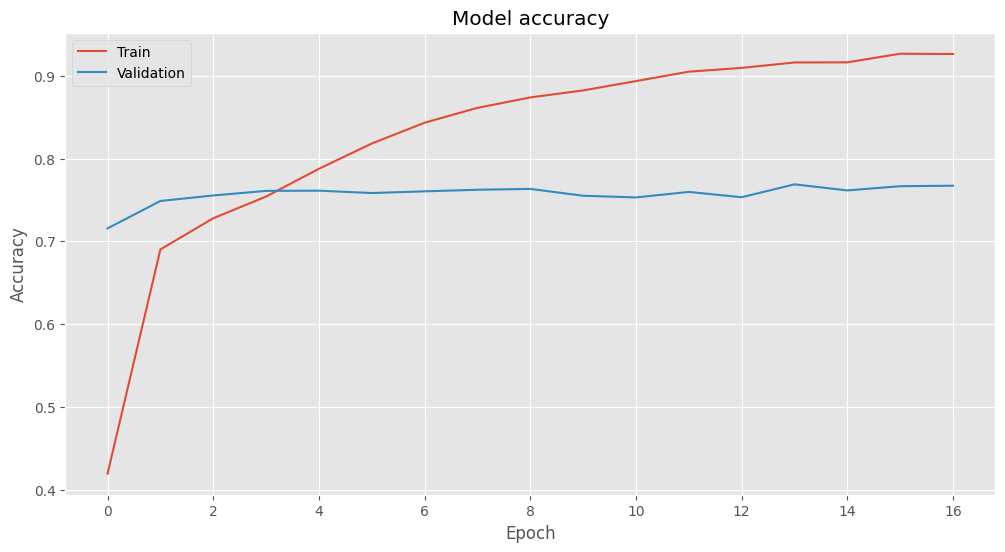

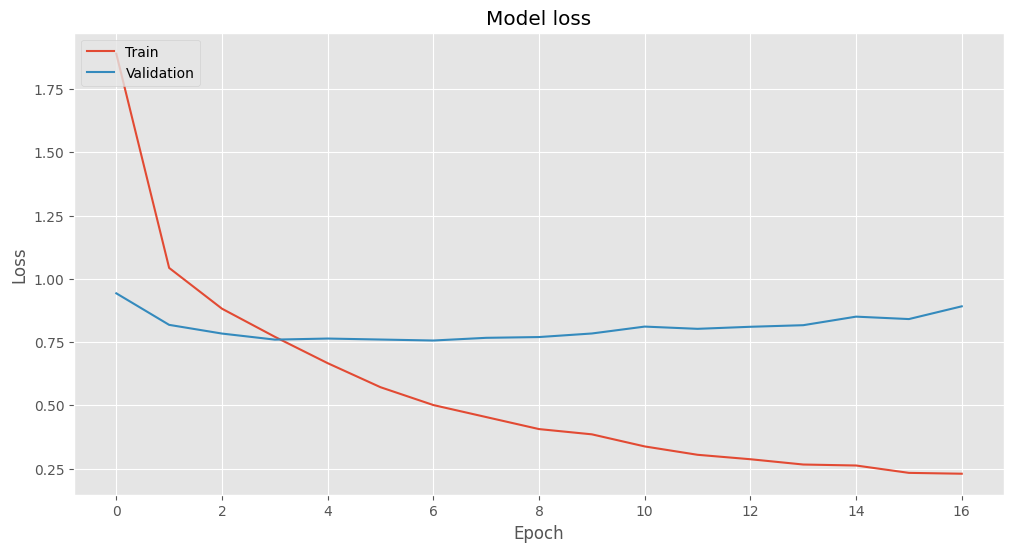

In [ ]:
from tensorflow.keras.layers import Conv1D, LayerNormalization

# Define Temporal Convolutional Network (TCN) Block
def tcn_block(x, filters, kernel_size, dilation_rate):
    tcn = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
    tcn = LayerNormalization()(tcn)
    return tcn

# Input Layer
inputs = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(inputs)

# TCN Block
model = tcn_block(model, filters=64, kernel_size=3, dilation_rate=1)
model = tcn_block(model, filters=64, kernel_size=3, dilation_rate=2)
model = tcn_block(model, filters=64, kernel_size=3, dilation_rate=4)

# Fully Connected Layer
model = Flatten()(model)
model = Dense(128, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(max_len * num_tags, activation='softmax')(model)
outputs = Reshape((max_len, num_tags))(model)

# Define the model
tcn_model = Model(inputs, outputs)

# Compile the model
tcn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and time tracking
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = tf.timestamp()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(tf.timestamp() - self.epoch_time_start)

time_callback = TimeHistory()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = tcn_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2, callbacks=[time_callback, early_stopping])

# Print model summary
tcn_model.summary()

# Print time per epoch
times = time_callback.times
print(f"Average time per epoch: {np.mean(times)} seconds")

# Evaluate CNN model
tcn_model_eval = tcn_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"tcn_model CNN Model - Loss: {tcn_model_eval[0]}, Accuracy: {tcn_model_eval[1]}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

ver 2

Epoch 1/200
23/23 [==============================] - 23s 181ms/step - loss: 1.9560 - accuracy: 0.4178 - val_loss: 0.9769 - val_accuracy: 0.7035
Epoch 2/200
23/23 [==============================] - 2s 94ms/step - loss: 1.1585 - accuracy: 0.6699 - val_loss: 0.8996 - val_accuracy: 0.7290
Epoch 3/200
23/23 [==============================] - 2s 76ms/step - loss: 1.0284 - accuracy: 0.6964 - val_loss: 0.8356 - val_accuracy: 0.7459
Epoch 4/200
23/23 [==============================] - 2s 107ms/step - loss: 0.9527 - accuracy: 0.7094 - val_loss: 0.8684 - val_accuracy: 0.7460
Epoch 5/200
23/23 [==============================] - 3s 118ms/step - loss: 0.9254 - accuracy: 0.7178 - val_loss: 0.7969 - val_accuracy: 0.7507
Epoch 6/200
23/23 [==============================] - 1s 63ms/step - loss: 0.8523 - accuracy: 0.7314 - val_loss: 0.8005 - val_accuracy: 0.7417
Epoch 7/200
23/23 [==============================] - 2s 72ms/step - loss: 0.8071 - accuracy: 0.7437 - val_loss: 0.7805 - val_accuracy: 0.7504
Ep

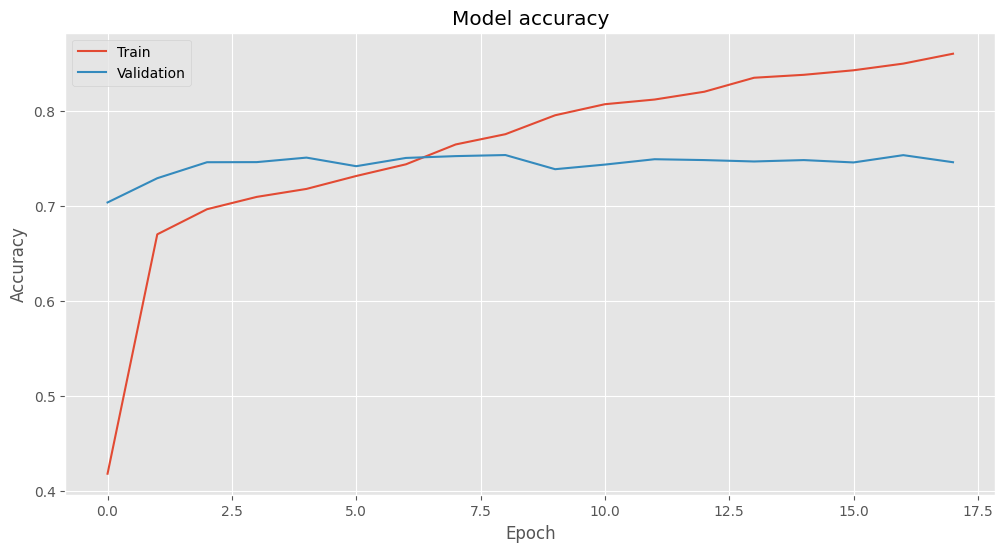

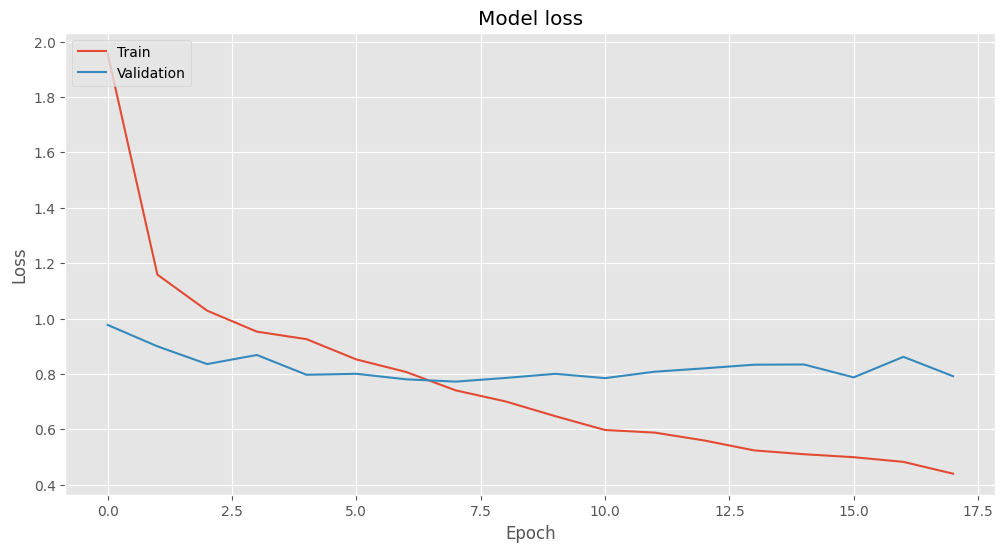

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, LayerNormalization, Dense, Dropout, Flatten, Reshape, LSTM, Add
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define Residual TCN Block with Skip Connection
def residual_tcn_block(x, filters, kernel_size, dilation_rate):
    tcn = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
    tcn = LayerNormalization()(tcn)
    # Adjust input shape if necessary
    if x.shape[-1] != filters:
        x = Conv1D(filters, 1, padding='same')(x)
    skip = Add()([x, tcn])
    return skip

# Define Encoder
def encoder(x, filters_list, kernel_size_list, dilation_rate_list):
    for filters, kernel_size, dilation_rate in zip(filters_list, kernel_size_list, dilation_rate_list):
        x = residual_tcn_block(x, filters, kernel_size, dilation_rate)
    encoded = LSTM(128, return_sequences=True)(x)
    return encoded

# Define Decoder
def decoder(x, filters_list, kernel_size_list, dilation_rate_list):
    decoded = LSTM(128, return_sequences=True)(x)
    for filters, kernel_size, dilation_rate in zip(filters_list, kernel_size_list, dilation_rate_list):
        decoded = residual_tcn_block(decoded, filters, kernel_size, dilation_rate)
    return decoded

# Input Layer
inputs = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(inputs)

# Encoder
encoder_filters = [64, 64, 64]
encoder_kernel_sizes = [3, 3, 3]
encoder_dilation_rates = [1, 2, 4]
encoded = encoder(model, encoder_filters, encoder_kernel_sizes, encoder_dilation_rates)

# Decoder
decoder_filters = [64, 64, 64]
decoder_kernel_sizes = [3, 3, 3]
decoder_dilation_rates = [4, 2, 1]
decoded = decoder(encoded, decoder_filters, decoder_kernel_sizes, decoder_dilation_rates)

# Fully Connected Layer
decoded = Flatten()(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dropout(0.5)(decoded)
decoded = Dense(max_len * num_tags, activation='softmax')(decoded)
outputs = Reshape((max_len, num_tags))(decoded)

# Define the model
tcn_model = Model(inputs, outputs)

# Compile the model
tcn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and time tracking
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = tf.timestamp()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(tf.timestamp() - self.epoch_time_start)

time_callback = TimeHistory()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = tcn_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2, callbacks=[time_callback, early_stopping])

# Print model summary
tcn_model.summary()

# Print time per epoch
times = time_callback.times
print(f"Average time per epoch: {np.mean(times)} seconds")

# Evaluate TCN model
tcn_model_eval = tcn_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"TCN Model - Loss: {tcn_model_eval[0]}, Accuracy: {tcn_model_eval[1]}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Multi Headed CNN

Epoch 1/200
23/23 [==============================] - 14s 261ms/step - loss: 1.8039 - accuracy: 0.4711 - val_loss: 0.9537 - val_accuracy: 0.6904
Epoch 2/200
23/23 [==============================] - 3s 131ms/step - loss: 1.0454 - accuracy: 0.6771 - val_loss: 0.8842 - val_accuracy: 0.7154
Epoch 3/200
23/23 [==============================] - 2s 95ms/step - loss: 0.9622 - accuracy: 0.6955 - val_loss: 0.8196 - val_accuracy: 0.7455
Epoch 4/200
23/23 [==============================] - 3s 112ms/step - loss: 0.8984 - accuracy: 0.7190 - val_loss: 0.7746 - val_accuracy: 0.7551
Epoch 5/200
23/23 [==============================] - 1s 55ms/step - loss: 0.8393 - accuracy: 0.7286 - val_loss: 0.7402 - val_accuracy: 0.7609
Epoch 6/200
23/23 [==============================] - 1s 51ms/step - loss: 0.7957 - accuracy: 0.7412 - val_loss: 0.7223 - val_accuracy: 0.7661
Epoch 7/200
23/23 [==============================] - 1s 38ms/step - loss: 0.7461 - accuracy: 0.7517 - val_loss: 0.7179 - val_accuracy: 0.7682
Ep

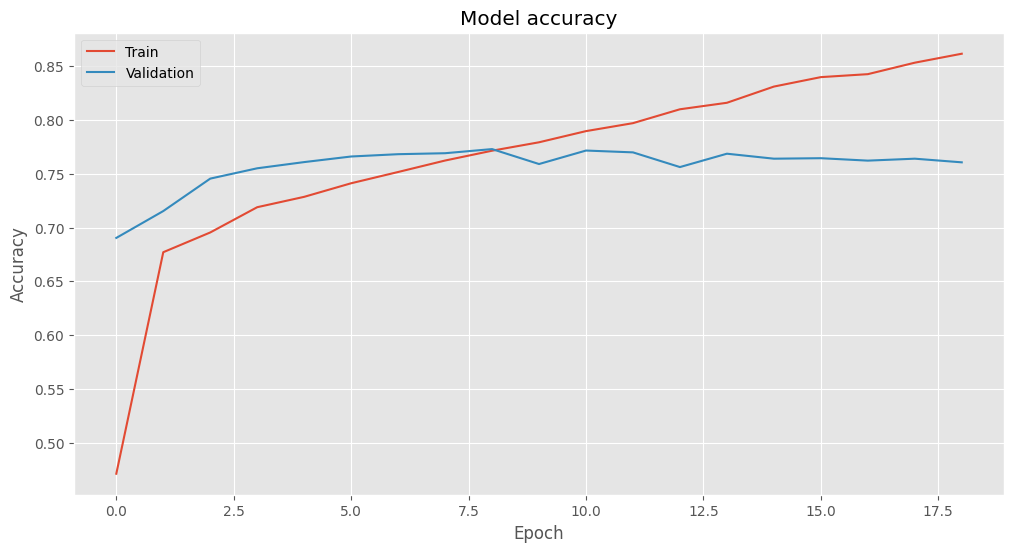

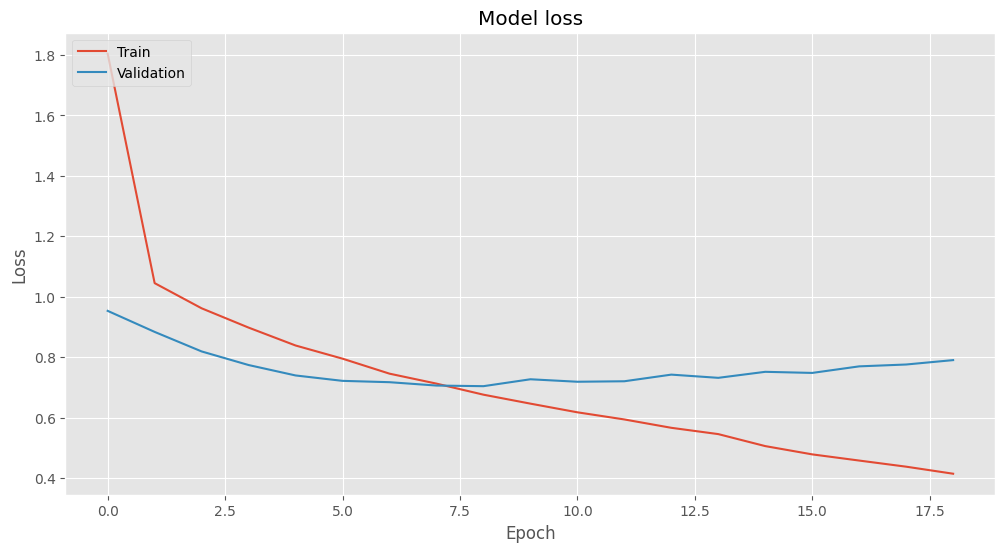

In [ ]:
from tensorflow.keras.layers import concatenate

# Define Multi-Head Convolutional Network Block
def multi_head_conv_block(x, filters):
    conv_heads = [Conv1D(filters, kernel_size=i, activation='relu', padding='same')(x) for i in range(2, 6)]
    return concatenate(conv_heads, axis=-1)

# Input Layer
inputs = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(inputs)

# Multi-Head Convolutional Block
model = multi_head_conv_block(model, filters=64)
model = MaxPooling1D(pool_size=2)(model)

# Fully Connected Layer
model = Flatten()(model)
model = Dense(128, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(max_len * num_tags, activation='softmax')(model)
outputs = Reshape((max_len, num_tags))(model)

# Define the model
multi_head_cnn_model = Model(inputs, outputs)

# Compile the model
multi_head_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and time tracking
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = tf.timestamp()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(tf.timestamp() - self.epoch_time_start)

time_callback = TimeHistory()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = multi_head_cnn_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2, callbacks=[time_callback, early_stopping])

# Print model summary
multi_head_cnn_model.summary()

# Print time per epoch
times = time_callback.times
print(f"Average time per epoch: {np.mean(times)} seconds")

# Evaluate TCN model
multi_head_cnn_model_eval = multi_head_cnn_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Multiheaded CNN Model - Loss: {multi_head_cnn_model_eval[0]}, Accuracy: {multi_head_cnn_model_eval[1]}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## FCN (tidak dipertimbangkan)

Epoch 1/200
23/23 [==============================] - 14s 346ms/step - loss: 2.3040 - accuracy: 0.5079 - val_loss: 1.1417 - val_accuracy: 0.6620
Epoch 2/200
23/23 [==============================] - 5s 218ms/step - loss: 1.0738 - accuracy: 0.6753 - val_loss: 0.9516 - val_accuracy: 0.6821
Epoch 3/200
23/23 [==============================] - 4s 142ms/step - loss: 0.9577 - accuracy: 0.6818 - val_loss: 0.9253 - val_accuracy: 0.6997
Epoch 4/200
23/23 [==============================] - 3s 120ms/step - loss: 0.9429 - accuracy: 0.6799 - val_loss: 0.9206 - val_accuracy: 0.6974
Epoch 5/200
23/23 [==============================] - 2s 89ms/step - loss: 0.9373 - accuracy: 0.6788 - val_loss: 0.9143 - val_accuracy: 0.7073
Epoch 6/200
23/23 [==============================] - 1s 65ms/step - loss: 0.9327 - accuracy: 0.6807 - val_loss: 0.9087 - val_accuracy: 0.7035
Epoch 7/200
23/23 [==============================] - 1s 41ms/step - loss: 0.9045 - accuracy: 0.6953 - val_loss: 0.8642 - val_accuracy: 0.7226
E

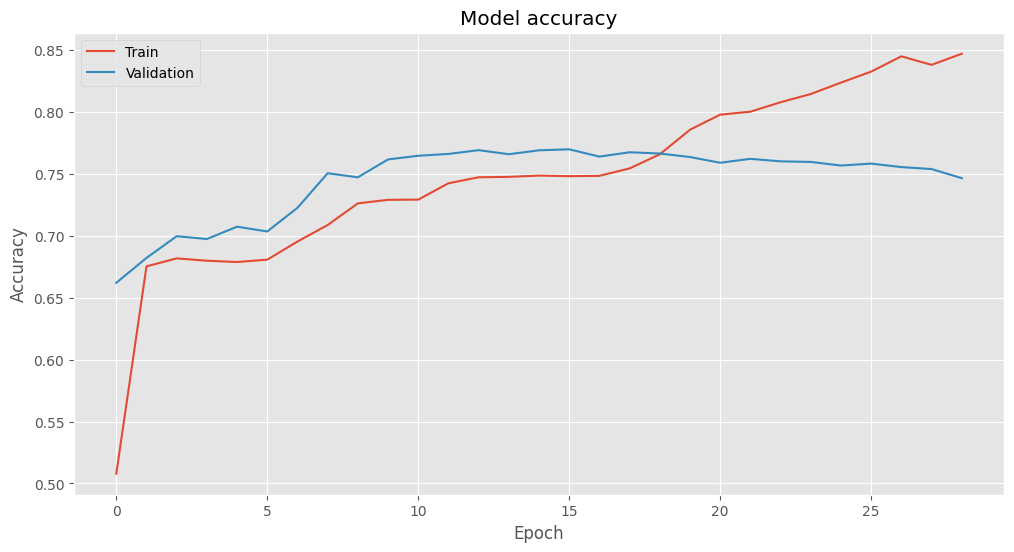

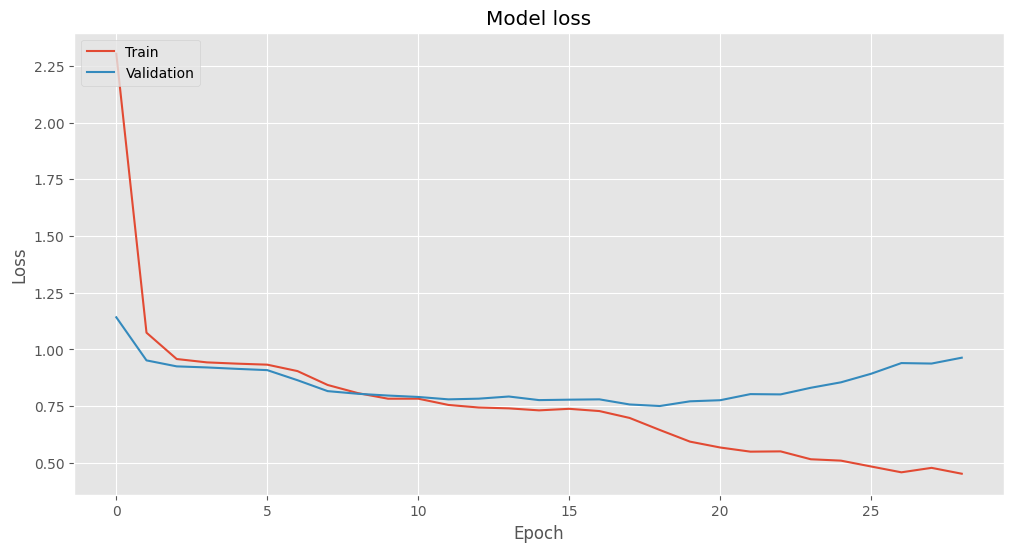

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, InputLayer, Reshape, GlobalAveragePooling1D

fcn_model = Sequential([
    InputLayer(input_shape=(max_len,)),
    Embedding(input_dim=num_words, output_dim=128, input_length=max_len),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    GlobalAveragePooling1D(),  # Mengganti Flatten dengan GlobalAveragePooling1D
    Dense(max_len * num_tags, activation='softmax'),
    Reshape((max_len, num_tags))
])

# Set learning rate
learning_rate = 0.001

# Compile the model with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
fcn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and time tracking
time_callback = TimeHistory()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = fcn_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2, callbacks=[time_callback, early_stopping])

# Print model summary
fcn_model.summary()

# Print time per epoch
times = time_callback.times
print(f"Average time per epoch: {np.mean(times)} seconds")

# Evaluate FCN model
fcn_eval = fcn_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"FCN Model - Loss: {fcn_eval[0]}, Accuracy: {fcn_eval[1]}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, InputLayer, Flatten, Reshape
from tensorflow.keras.models import Sequential

max_len = 100  # Panjang maksimum kalimat
num_words = 10000  # Jumlah kata unik dalam kamus
num_tags = 5  # Jumlah tag segmentasi

fcn_model = Sequential([
    InputLayer(input_shape=(max_len, 1)),  # Dimensi input (max_len, 1) untuk teks 1D
    Embedding(input_dim=num_words, output_dim=128, input_length=max_len),

    Conv2D(filters=128, kernel_size=(3, 1), activation='relu', padding='same'),  # Kernel size (3, 1) untuk menangkap dependensi antar kata

    Conv2D(filters=64, kernel_size=(3, 1), activation='relu', padding='same'),

    MaxPooling2D(pool_size=(2, 1)),

    Conv2D(filters=64, kernel_size=(3, 1), activation='relu', padding='same'),

    Flatten(),  # Meratakan output dari lapisan convolutional terakhir

    Dense(max_len * num_tags, activation='softmax'),

    Reshape((max_len, num_tags))
    ])

# Set learning rate
learning_rate = 0.001

# Compile the model with a specific learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
fcn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = fcn_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2)

# Evaluate FCN model
fcn_eval = fcn_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"FCN Model - Loss: {fcn_eval[0]}, Accuracy: {fcn_eval[1]}")


Epoch 1/200


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 100, 1), found shape=(None, 50)


## Capsule Network

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load and preprocess data
data = pd.read_csv("/content/drive/MyDrive/MY NER PROJECT/ner_karhutla.csv", encoding="latin1")
data = data.fillna(method="ffill")
data["Tag"].fillna("O", inplace=True)

# Prepare unique word and tag lists
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

tags = list(set(data["Tag"].values))
num_tags = len(tags)

# Helper class to get sentences
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(), s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sentences = getter.sentences

# Create word and tag indices
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

# Define max length for padding
max_len = 50

# Convert sentences to sequences of word indices
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

# Convert tags to sequences of tag indices
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

# Convert labels to one-hot encoding
y = [to_categorical(i, num_classes=num_tags) for i in y]

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, dim_capsules, routings=3, kernel_initializer='glorot_uniform', **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules
        self.routings = routings
        self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)

    def build(self, input_shape):
        self.input_num_capsules = input_shape[1]
        self.input_dim_capsules = input_shape[2]
        self.W = self.add_weight(shape=[self.input_num_capsules, self.num_capsules, self.input_dim_capsules, self.dim_capsules],
                                 initializer=self.kernel_initializer, name='W')

    def call(self, inputs):
        inputs_expand = tf.expand_dims(inputs, 2)
        inputs_tiled = tf.tile(inputs_expand, [1, 1, self.num_capsules, 1])
        inputs_tiled = tf.expand_dims(inputs_tiled, -1)
        inputs_hat = tf.reduce_sum(self.W * inputs_tiled, axis=3, keepdims=True)
        inputs_hat = tf.squeeze(inputs_hat, axis=3)

        b = tf.zeros(shape=[tf.shape(inputs)[0], self.input_num_capsules, self.num_capsules])

        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            outputs = squash(tf.einsum('bij,bijk->bik', c, inputs_hat))
            if i < self.routings - 1:
                b += tf.einsum('bik,bijk->bij', outputs, inputs_hat)

        return outputs

def squash(vector):
    s_squared_norm = tf.reduce_sum(tf.square(vector), -1, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
    return scale * vector

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Reshape
from tensorflow.keras.models import Model

# Define Capsule Network model
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(input_layer)
reshape_layer = Reshape((max_len, 128))(embedding_layer)

# Primary Capsule Layer
primary_caps = CapsuleLayer(num_capsules=10, dim_capsules=16, routings=3)(reshape_layer)

# Digit Capsule Layer
digit_caps = CapsuleLayer(num_capsules=max_len, dim_capsules=num_tags, routings=3)(primary_caps)

# Reshape and output
output_layer = Reshape((max_len, num_tags))(digit_caps)

capsule_model = Model(inputs=input_layer, outputs=output_layer)
capsule_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/200
23/23 [==============================] - 9s 165ms/step - loss: 11.3336 - accuracy: 0.3044 - val_loss: 12.4133 - val_accuracy: 0.3553
Epoch 2/200
23/23 [==============================] - 2s 77ms/step - loss: 12.2872 - accuracy: 0.3522 - val_loss: 12.3176 - val_accuracy: 0.3574
Epoch 3/200
23/23 [==============================] - 2s 76ms/step - loss: 12.5368 - accuracy: 0.3655 - val_loss: 12.5699 - val_accuracy: 0.3716
Epoch 4/200
23/23 [==============================] - 2s 71ms/step - loss: 12.5802 - accuracy: 0.3597 - val_loss: 12.4263 - val_accuracy: 0.3579
Epoch 5/200
23/23 [==============================] - 2s 98ms/step - loss: 11.7564 - accuracy: 0.3367 - val_loss: 11.1478 - val_accuracy: 0.3364
Epoch 6/200
23/23 [==============================] - 2s 97ms/step - loss: 11.4844 - accuracy: 0.3202 - val_loss: 12.2079 - val_accuracy: 0.2991
Epoch 7/200
23/23 [==============================] - 1s 53ms/step - loss: 12.1345 - accuracy: 0.3036 - val_loss: 11.9157 - val_accuracy

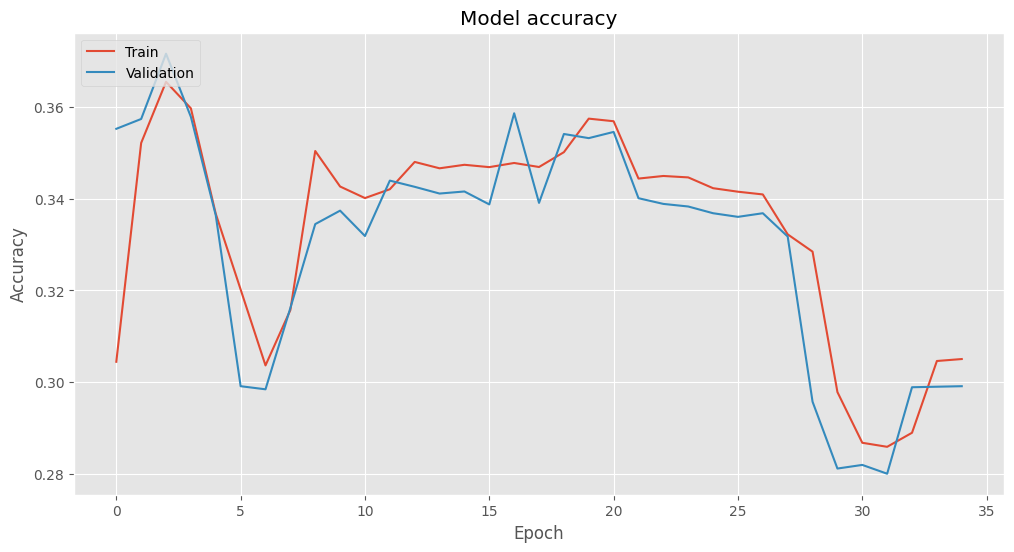

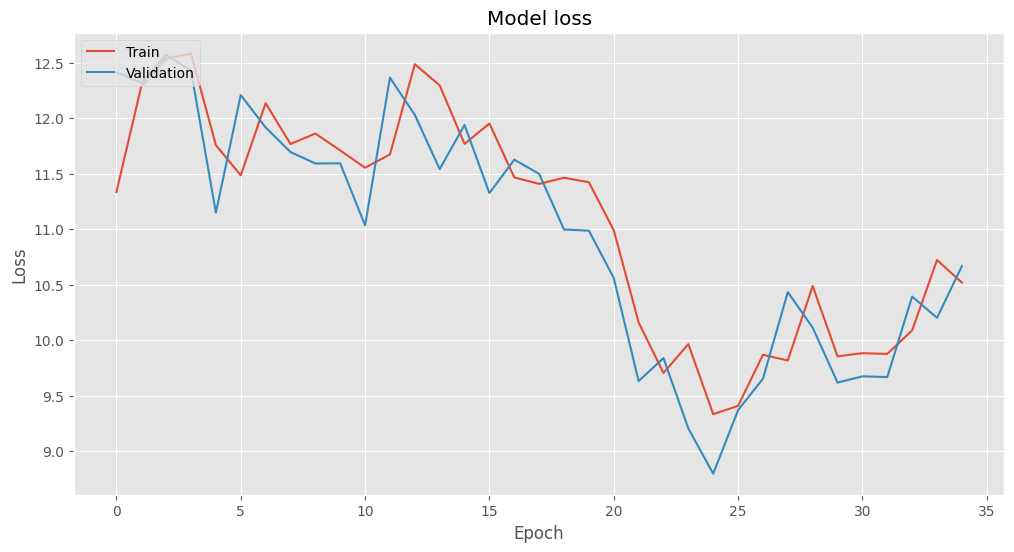

In [ ]:
# Define callbacks for early stopping and time tracking
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = tf.timestamp()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(tf.timestamp() - self.epoch_time_start)

time_callback = TimeHistory()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Capsule Network model
history_capsule = capsule_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2, callbacks=[time_callback, early_stopping])

# Print model summary
capsule_model.summary()

# Print time per epoch
times = time_callback.times
print(f"Average time per epoch: {np.mean(times)} seconds")

# Evaluate Capsule Network model
capsule_eval = capsule_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Capsule Network Model - Loss: {capsule_eval[0]}, Accuracy: {capsule_eval[1]}")

# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history_capsule.history['accuracy'])
plt.plot(history_capsule.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_capsule.history['loss'])
plt.plot(history_capsule.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

modified caps-net

In [ ]:
# Ensure padding and sequence conversion is correct
X = pad_sequences(maxlen=max_len, sequences=[[word2idx.get(w[0], 0) for w in s] for s in sentences], padding="post", value=num_words-1)
y = pad_sequences(maxlen=max_len, sequences=[[tag2idx.get(w[1], 0) for w in s] for s in sentences], padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

Epoch 1/200
23/23 [==============================] - 12s 429ms/step - loss: 9.1654 - accuracy: 0.3592 - val_loss: 9.0819 - val_accuracy: 0.3656 - lr: 0.0010
Epoch 2/200
23/23 [==============================] - 4s 168ms/step - loss: 10.8793 - accuracy: 0.3966 - val_loss: 12.4508 - val_accuracy: 0.3950 - lr: 0.0010
Epoch 3/200
23/23 [==============================] - 4s 169ms/step - loss: 10.8895 - accuracy: 0.4034 - val_loss: 9.1858 - val_accuracy: 0.3890 - lr: 0.0010
Epoch 4/200
23/23 [==============================] - 4s 178ms/step - loss: 8.9183 - accuracy: 0.4035 - val_loss: 8.8174 - val_accuracy: 0.3878 - lr: 0.0010
Epoch 5/200
23/23 [==============================] - 2s 98ms/step - loss: 8.3812 - accuracy: 0.4007 - val_loss: 7.0652 - val_accuracy: 0.3937 - lr: 0.0010
Epoch 6/200
23/23 [==============================] - 1s 50ms/step - loss: 7.0479 - accuracy: 0.4059 - val_loss: 6.5382 - val_accuracy: 0.3911 - lr: 0.0010
Epoch 7/200
23/23 [==============================] - 2s 68ms/s

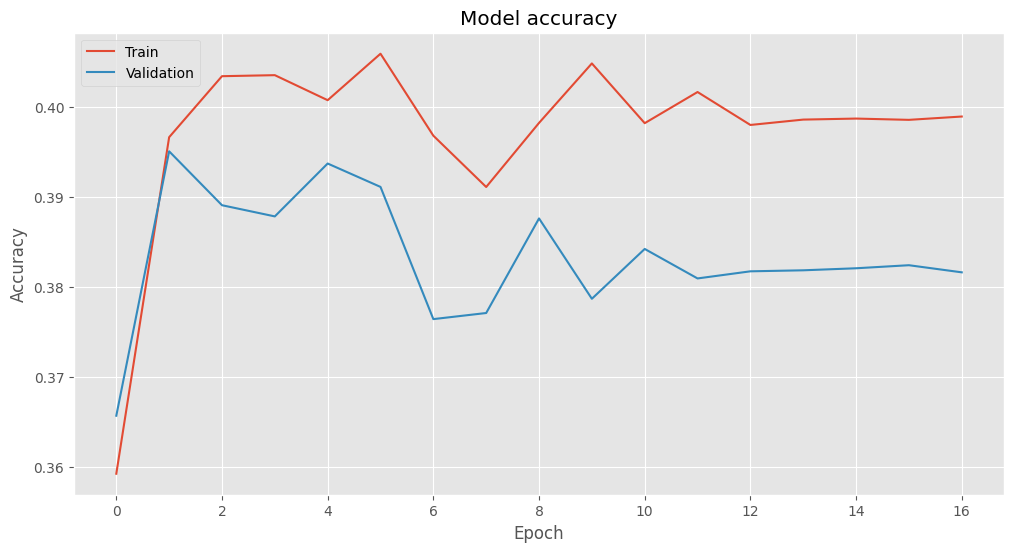

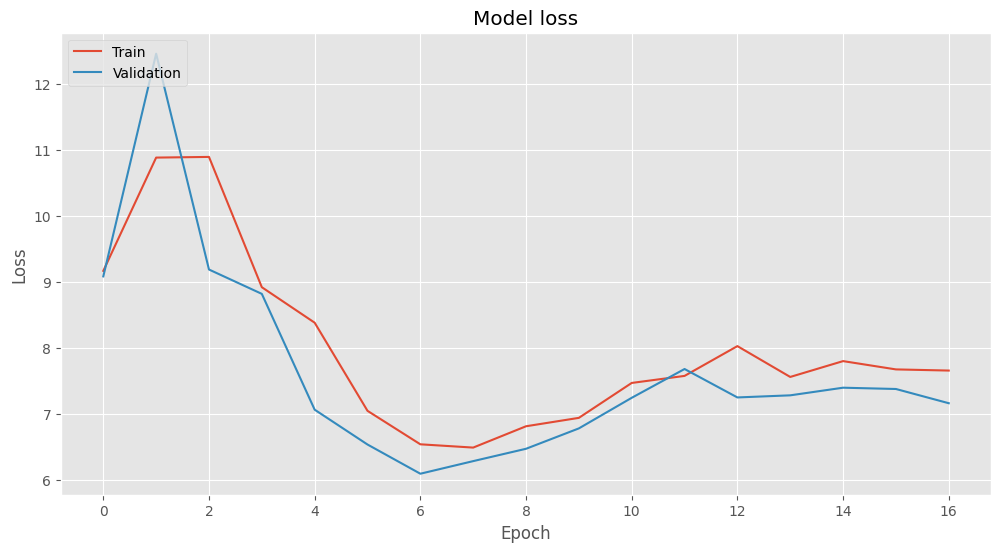

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
import numpy as np

class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = tf.timestamp()

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(tf.timestamp() - self.epoch_time_start)

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile the model with a smaller learning rate
optimizer = Adam(learning_rate=0.001)
capsule_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_capsule = capsule_model.fit(
    x_train,
    np.array(y_train),
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[TimeHistory(), early_stopping, reduce_lr]
)

# Evaluate the model
capsule_eval = capsule_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Capsule Network Model - Loss: {capsule_eval[0]}, Accuracy: {capsule_eval[1]}")

# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history_capsule.history['accuracy'])
plt.plot(history_capsule.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_capsule.history['loss'])
plt.plot(history_capsule.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

modified 2

In [ ]:
import os
import numpy as np

# Download GloVe embeddings if not already downloaded
!wget http://nlp.stanford.edu/data/glove.6B.zip -P /content/
!unzip /content/glove.6B.zip -d /content/glove.6B

# Load GloVe embeddings
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_file_path = '/content/glove.6B/glove.6B.100d.txt'
glove_vectors = load_glove_embeddings(glove_file_path)

--2024-06-10 15:17:47--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-06-10 15:17:47--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-06-10 15:17:47--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/content/glove.6B.z

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt

# Download GloVe embeddings if not already downloaded
!wget http://nlp.stanford.edu/data/glove.6B.zip -P /content/
!unzip /content/glove.6B.zip -d /content/glove.6B

# Load GloVe embeddings
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_file_path = '/content/glove.6B/glove.6B.100d.txt'
glove_vectors = load_glove_embeddings(glove_file_path)

# Load and preprocess data
data = pd.read_csv("/content/drive/MyDrive/MY NER PROJECT/ner_karhutla.csv", encoding="latin1")
data = data.fillna(method="ffill")
data["Tag"].fillna("O", inplace=True)

# Prepare unique word and tag lists
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

tags = list(set(data["Tag"].values))
num_tags = len(tags)

# Helper class to get sentences
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(), s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sentences = getter.sentences

# Create word and tag indices
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

# Define max length for padding
max_len = 50

# Convert sentences to sequences of word indices
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

# Convert tags to sequences of tag indices
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

# Convert labels to one-hot encoding
y = [to_categorical(i, num_classes=num_tags) for i in y]

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Load pre-trained embeddings if available
# Example: Using GloVe embeddings
embedding_matrix = np.zeros((num_words, 100))
for word, i in word2idx.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(
    input_dim=num_words,
    output_dim=100,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=False
)(input_layer)
reshape_layer = Reshape((max_len, 100))(embedding_layer)

# Capsule Network layers with regularization and dropout
primary_caps = CapsuleLayer(num_capsules=10, dim_capsules=16, routings=3, kernel_initializer='glorot_uniform')(reshape_layer)
primary_caps = Dropout(0.5)(primary_caps)

digit_caps = CapsuleLayer(num_capsules=max_len, dim_capsules=num_tags, routings=3, kernel_initializer='glorot_uniform')(primary_caps)
digit_caps = Dropout(0.5)(digit_caps)

# Reshape and output
output_layer = Reshape((max_len, num_tags))(digit_caps)

capsule_model = Model(inputs=input_layer, outputs=output_layer)

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define a custom callback to measure time per epoch
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = tf.timestamp()

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(tf.timestamp() - self.epoch_time_start)

# Compile the model with a smaller learning rate
optimizer = Adam(learning_rate=0.001)
capsule_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Capsule Network model
history_capsule = capsule_model.fit(
    x_train,
    np.array(y_train),
    epochs=200,
    batch_size=64,
    validation_split=0.2,
    callbacks=[TimeHistory(), early_stopping, reduce_lr]
)

# Print model summary
capsule_model.summary()

# Print time per epoch
time_callback = TimeHistory()
times = time_callback.times
print(f"Average time per epoch: {np.mean(times)} seconds")

# Evaluate Capsule Network model
capsule_eval = capsule_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Capsule Network Model - Loss: {capsule_eval[0]}, Accuracy: {capsule_eval[1]}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history_capsule.history['accuracy'])
plt.plot(history_capsule.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_capsule.history['loss'])
plt.plot(history_capsule.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

--2024-06-10 15:21:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-06-10 15:21:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-06-10 15:21:09--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/content/glove.6B.z

12/12 [==============================] - 3s 67ms/step - loss: nan - accuracy: 0.3694 - val_loss: nan - val_accuracy: 0.6569 - lr: 0.0010
Epoch 2/200
12/12 [==============================] - 0s 28ms/step - loss: nan - accuracy: 0.3418 - val_loss: nan - val_accuracy: 0.6569 - lr: 0.0010
Epoch 3/200
12/12 [==============================] - 0s 29ms/step - loss: nan - accuracy: 0.3430 - val_loss: nan - val_accuracy: 0.6569 - lr: 0.0010
Epoch 4/200
12/12 [==============================] - 0s 28ms/step - loss: nan - accuracy: 0.3439 - val_loss: nan - val_accuracy: 0.6569 - lr: 0.0010
Epoch 5/200
12/12 [==============================] - 0s 26ms/step - loss: nan - accuracy: 0.3425 - val_loss: nan - val_accuracy: 0.6569 - lr: 0.0010
Epoch 6/200
12/12 [==============================] - 0s 24ms/step - loss: nan - accuracy: 0.3453 - val_loss: nan - val_accuracy: 0.6569 - lr: 5.0000e-04
Epoch 7/200
12/12 [==============================] - 0s 25ms/step - loss: nan - accuracy: 0.3432 - val_loss: nan -

AttributeError: 'TimeHistory' object has no attribute 'times'

Epoch 1/200
 5/12 [===========>..................] - ETA: 0s - loss: nan - accuracy: 0.4063

12/12 [==============================] - 2s 52ms/step - loss: nan - accuracy: 0.3721 - val_loss: nan - val_accuracy: 0.6569 - lr: 0.0010
Epoch 2/200
12/12 [==============================] - 0s 23ms/step - loss: nan - accuracy: 0.3435 - val_loss: nan - val_accuracy: 0.6569 - lr: 0.0010
Epoch 3/200
12/12 [==============================] - 0s 23ms/step - loss: nan - accuracy: 0.3402 - val_loss: nan - val_accuracy: 0.6569 - lr: 0.0010
Epoch 4/200
12/12 [==============================] - 0s 23ms/step - loss: nan - accuracy: 0.3391 - val_loss: nan - val_accuracy: 0.6569 - lr: 0.0010
Epoch 5/200
12/12 [==============================] - 0s 23ms/step - loss: nan - accuracy: 0.3397 - val_loss: nan - val_accuracy: 0.6569 - lr: 0.0010
Epoch 6/200
12/12 [==============================] - 0s 26ms/step - loss: nan - accuracy: 0.3446 - val_loss: nan - val_accuracy: 0.6569 - lr: 5.0000e-04
Epoch 7/200
12/12 [==============================] - 0s 23ms/step - loss: nan - accuracy: 0.3419 - val_loss: nan -

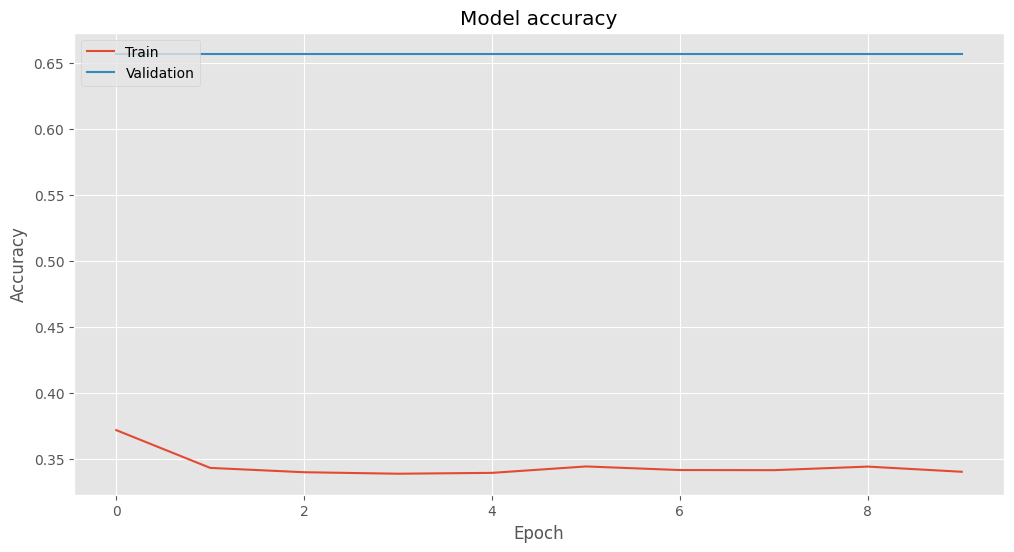

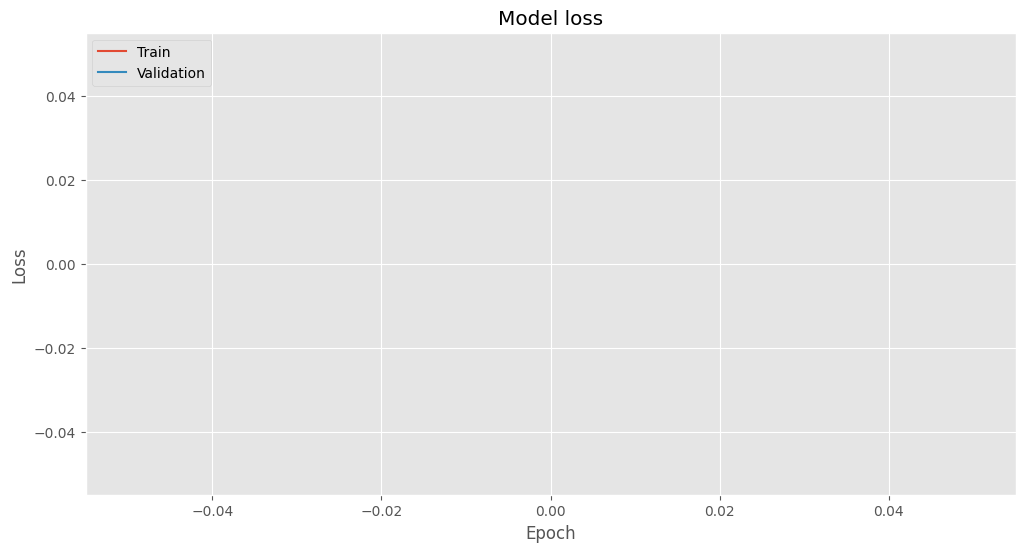

In [ ]:
# Load GloVe embeddings
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_file_path = '/content/glove.6B/glove.6B.100d.txt'
glove_vectors = load_glove_embeddings(glove_file_path)

# Load and preprocess data
data = pd.read_csv("/content/drive/MyDrive/MY NER PROJECT/ner_karhutla.csv", encoding="latin1")
data = data.fillna(method="ffill")
data["Tag"].fillna("O", inplace=True)

# Prepare unique word and tag lists
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

tags = list(set(data["Tag"].values))
num_tags = len(tags)

# Helper class to get sentences
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(), s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sentences = getter.sentences

# Create word and tag indices
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

# Define max length for padding
max_len = 50

# Convert sentences to sequences of word indices
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

# Convert tags to sequences of tag indices
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

# Convert labels to one-hot encoding
y = [to_categorical(i, num_classes=num_tags) for i in y]

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Load pre-trained embeddings if available
# Example: Using GloVe embeddings
embedding_matrix = np.zeros((num_words, 100))
for word, i in word2idx.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(
    input_dim=num_words,
    output_dim=100,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=False
)(input_layer)
reshape_layer = Reshape((max_len, 100))(embedding_layer)

# Capsule Network layers with regularization and dropout
primary_caps = CapsuleLayer(num_capsules=10, dim_capsules=16, routings=3, kernel_initializer='glorot_uniform')(reshape_layer)
primary_caps = Dropout(0.5)(primary_caps)

digit_caps = CapsuleLayer(num_capsules=max_len, dim_capsules=num_tags, routings=3, kernel_initializer='glorot_uniform')(primary_caps)
digit_caps = Dropout(0.5)(digit_caps)

# Reshape and output
output_layer = Reshape((max_len, num_tags))(digit_caps)

capsule_model = Model(inputs=input_layer, outputs=output_layer)

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define a custom callback to measure time per epoch
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = tf.timestamp()

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(tf.timestamp() - self.epoch_time_start)

# Instantiate the TimeHistory callback
time_callback = TimeHistory()

# Compile the model with a smaller learning rate
optimizer = Adam(learning_rate=0.001)
capsule_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Capsule Network model
history_capsule = capsule_model.fit(
    x_train,
    np.array(y_train),
    epochs=200,
    batch_size=64,
    validation_split=0.2,
    callbacks=[time_callback, early_stopping, reduce_lr]
)

# Print model summary
capsule_model.summary()

# Print time per epoch
times = time_callback.times
print(f"Average time per epoch: {np.mean(times)} seconds")

# Evaluate Capsule Network model
capsule_eval = capsule_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Capsule Network Model - Loss: {capsule_eval[0]}, Accuracy: {capsule_eval[1]}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history_capsule.history['accuracy'])
plt.plot(history_capsule.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_capsule.history['loss'])
plt.plot(history_capsule.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt

# Download GloVe embeddings if not already downloaded
!wget http://nlp.stanford.edu/data/glove.6B.zip -P /content/
!unzip /content/glove.6B.zip -d /content/glove.6B

# Load GloVe embeddings
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_file_path = '/content/glove.6B/glove.6B.100d.txt'
glove_vectors = load_glove_embeddings(glove_file_path)

# Load and preprocess data
data = pd.read_csv("/content/drive/MyDrive/MY NER PROJECT/ner_karhutla.csv", encoding="latin1")
data = data.fillna(method="ffill")
data["Tag"].fillna("O", inplace=True)

# Prepare unique word and tag lists
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

tags = list(set(data["Tag"].values))
num_tags = len(tags)

# Helper class to get sentences
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(), s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sentences = getter.sentences

# Create word and tag indices
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

# Define max length for padding
max_len = 50

# Convert sentences to sequences of word indices
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

# Convert tags to sequences of tag indices
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

# Convert labels to one-hot encoding
y = [to_categorical(i, num_classes=num_tags) for i in y]

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Load pre-trained embeddings if available
# Example: Using GloVe embeddings
embedding_matrix = np.zeros((num_words, 100))
for word, i in word2idx.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define Capsule Layer
class CapsuleLayer(tf.keras.layers.Layer):
    def __init__(self, num_capsules, dim_capsules, routings=3, kernel_initializer='glorot_uniform', **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules
        self.routings = routings
        self.kernel_initializer = kernel_initializer

    def build(self, input_shape):
        self.input_num_capsules = input_shape[1]
        self.input_dim_capsules = input_shape[2]
        self.W = self.add_weight(shape=[self.input_num_capsules, self.num_capsules, self.input_dim_capsules, self.dim_capsules],
                                 initializer=self.kernel_initializer,
                                 trainable=True)

    def call(self, inputs):
        inputs_expand = tf.expand_dims(inputs, 2)
        inputs_tiled = tf.tile(inputs_expand, [1, 1, self.num_capsules, 1])
        inputs_hat = tf.linalg.matvec(self.W, inputs_tiled)
        b = tf.zeros(shape=[tf.shape(inputs)[0], self.input_num_capsules, self.num_capsules])

        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            s = tf.reduce_sum(tf.expand_dims(c, -1) * inputs_hat, axis=1)
            v = squash(s)
            if i < self.routings - 1:
                b += tf.reduce_sum(inputs_hat * tf.expand_dims(v, 1), axis=-1)

        return v

def squash(vector):
    s_squared_norm = tf.reduce_sum(tf.square(vector), -1, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm)
    return scale * vector / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())

input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(
    input_dim=num_words,
    output_dim=100,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=False
)(input_layer)
reshape_layer = Reshape((max_len, 100))(embedding_layer)

# Capsule Network layers with regularization and dropout
primary_caps = CapsuleLayer(num_capsules=10, dim_capsules=16, routings=3, kernel_initializer='glorot_uniform')(reshape_layer)
primary_caps = Dropout(0.5)(primary_caps)

digit_caps = CapsuleLayer(num_capsules=max_len, dim_capsules=num_tags, routings=3, kernel_initializer='glorot_uniform')(primary_caps)
digit_caps = Dropout(0.5)(digit_caps)

# Reshape and output
output_layer = Reshape((max_len, num_tags))(digit_caps)

capsule_model = Model(inputs=input_layer, outputs=output_layer)

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define a custom callback to measure time per epoch
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = tf.timestamp()

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(tf.timestamp() - self.epoch_time_start)

# Instantiate the TimeHistory callback
time_callback = TimeHistory()

# Compile the model with a smaller learning rate and gradient clipping
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
capsule_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Capsule Network model
history_capsule = capsule_model.fit(
    x_train,
    np.array(y_train),
    epochs=200,
    batch_size=64,
    validation_split=0.2,
    callbacks=[time_callback, early_stopping, reduce_lr]
)

# Print model summary
capsule_model.summary()

# Print time per epoch
times = time_callback.times
print(f"Average time per epoch: {np.mean(times)} seconds")

# Evaluate Capsule Network model
capsule_eval = capsule_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Capsule Network Model - Loss: {capsule_eval[0]}, Accuracy: {capsule_eval[1]}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history_capsule.history['accuracy'])
plt.plot(history_capsule.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_capsule.history['loss'])
plt.plot(history_capsule.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

--2024-06-10 15:31:17--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-06-10 15:31:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-06-10 15:31:18--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/content/glove.6B.z

ValueError: Exception encountered when calling layer "capsule_layer_8" (type CapsuleLayer).

in user code:

    File "<ipython-input-21-1c38b2addb09>", line 115, in call  *
        inputs_hat = tf.linalg.matvec(self.W, inputs_tiled)

    ValueError: Dimensions must be equal, but are 16 and 100 for '{{node capsule_layer_8/MatVec/MatMul}} = BatchMatMulV2[T=DT_FLOAT, adj_x=false, adj_y=false](capsule_layer_8/MatVec/MatMul/ReadVariableOp, capsule_layer_8/MatVec/ExpandDims)' with input shapes: [50,10,100,16], [?,50,10,100,1].


Call arguments received by layer "capsule_layer_8" (type CapsuleLayer):
  • inputs=tf.Tensor(shape=(None, 50, 100), dtype=float32)

# ARSIP SEMENTARA

### Capsule Networks

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
import numpy as np

class CapsuleLayer(Layer):
    def __init__(self, num_capsules, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        self.W = self.add_weight(shape=[input_shape[-2], self.num_capsules * self.dim_capsule],
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(CapsuleLayer, self).build(input_shape)

    def call(self, inputs):
        inputs_expand = K.expand_dims(inputs, 2)
        inputs_tile = K.tile(inputs_expand, [1, 1, self.num_capsules, 1])
        inputs_hat = tf.linalg.matmul(inputs_tile, self.W)
        inputs_hat = tf.reshape(inputs_hat, (-1, inputs.shape[1], self.num_capsules, self.dim_capsule))

        b = K.zeros_like(inputs_hat[:, :, :, 0])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            o = squash(tf.reduce_sum(c[..., tf.newaxis] * inputs_hat, axis=1, keepdims=True))
            if i < self.routings - 1:
                b = tf.reduce_sum(inputs_hat * o, axis=-1)
        return tf.reshape(o, [-1, self.num_capsules, self.dim_capsule])

def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

# Define CapsNet model
input_layer = layers.Input(shape=(max_len,))
embedding_layer = layers.Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(input_layer)
conv1 = layers.Conv1D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu')(embedding_layer)
primary_caps = layers.Conv1D(filters=32 * 8, kernel_size=9, strides=2, padding='valid', activation='relu')(conv1)
primary_caps_reshaped = layers.Reshape(target_shape=[-1, 8])(primary_caps)

capsule_layer = CapsuleLayer(num_capsules=num_tags, dim_capsule=16, routings=3)(primary_caps_reshaped)
output_capsule = layers.Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_layer)

# Compile the model
capsnet_model = models.Model(inputs=input_layer, outputs=output_capsule)
capsnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
capsnet_model.fit(x_train, np.array(y_train), epochs=50, batch_size=32, validation_split=0.2)

ValueError: Exception encountered when calling layer "capsule_layer_5" (type CapsuleLayer).

in user code:

    File "<ipython-input-15-b7b216bae76e>", line 23, in call  *
        inputs_hat = tf.linalg.matmul(inputs_tile, self.W)

    ValueError: Dimensions must be equal, but are 8 and 544 for '{{node capsule_layer_5/MatMul}} = BatchMatMulV2[T=DT_FLOAT, adj_x=false, adj_y=false](capsule_layer_5/Tile, capsule_layer_5/MatMul/ReadVariableOp)' with input shapes: [?,544,14,8], [544,224].


Call arguments received by layer "capsule_layer_5" (type CapsuleLayer):
  • inputs=tf.Tensor(shape=(None, 544, 8), dtype=float32)

NameError: name 'capsule_history' is not defined

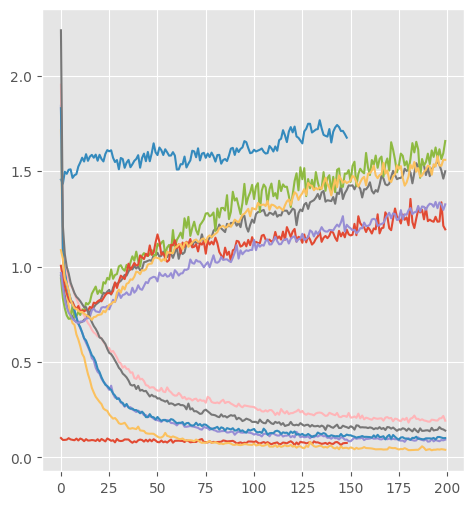

In [ ]:
# Plotting the results for the original CNN and all variations
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Original CNN - Train Loss')
plt.plot(history.history['val_loss'], label='Original CNN - Val Loss')
plt.plot(dilated_cnn_history.history['loss'], label='Dilated CNN - Train Loss')
plt.plot(dilated_cnn_history.history['val_loss'], label='Dilated CNN - Val Loss')
plt.plot(residual_cnn_history.history['loss'], label='Residual CNN - Train Loss')
plt.plot(residual_cnn_history.history['val_loss'], label='Residual CNN - Val Loss')
plt.plot(attention_cnn_history.history['loss'], label='Attention CNN - Train Loss')
plt.plot(attention_cnn_history.history['val_loss'], label='Attention CNN - Val Loss')
plt.plot(inception_cnn_history.history['loss'], label='Inception CNN - Train Loss')
plt.plot(inception_cnn_history.history['val_loss'], label='Inception CNN - Val Loss')
plt.plot(depthwise_separable_cnn_history.history['loss'], label='Depthwise Separable CNN - Train Loss')
plt.plot(depthwise_separable_cnn_history.history['val_loss'], label='Depthwise Separable CNN - Val Loss')
plt.plot(capsule_history.history['loss'], label='Capsule Network - Train Loss')
plt.plot(capsule_history.history['val_loss'], label='Capsule Network - Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Original CNN - Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Original CNN - Val Accuracy')
plt.plot(dilated_cnn_history.history['accuracy'], label='Dilated CNN - Train Accuracy')
plt.plot(dilated_cnn_history.history['val_accuracy'], label='Dilated CNN - Val Accuracy')
plt.plot(residual_cnn_history.history['accuracy'], label='Residual CNN - Train Accuracy')
plt.plot(residual_cnn_history.history['val_accuracy'], label='Residual CNN - Val Accuracy')
plt.plot(attention_cnn_history.history['accuracy'], label='Attention CNN - Train Accuracy')
plt.plot(attention_cnn_history.history['val_accuracy'], label='Attention CNN - Val Accuracy')
plt.plot(inception_cnn_history.history['accuracy'], label='Inception CNN - Train Accuracy')
plt.plot(inception_cnn_history.history['val_accuracy'], label='Inception CNN - Val Accuracy')
plt.plot(depthwise_separable_cnn_history.history['accuracy'], label='Depthwise Separable CNN - Train Accuracy')
plt.plot(depthwise_separable_cnn_history.history['val_accuracy'], label='Depthwise Separable CNN - Val Accuracy')
plt.plot(capsule_history.history['accuracy'], label='Capsule Network - Train Accuracy')
plt.plot(capsule_history.history['val_accuracy'], label='Capsule Network - Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Hybrid CNNs

### Hybrid CNN BILSTM

In [ ]:
# Define Hybrid Model (CNN + BiLSTM)
inputs = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(inputs)
model = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(model)
model = MaxPooling1D(pool_size=2)(model)
model = Bidirectional(LSTM(units=64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(model)

# Fully Connected Layer
model = TimeDistributed(Dense(num_tags, activation='softmax'))(model)

# Define the model
hybrid_model = Model(inputs, model)

# Compile the model
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and save training history
hybrid_history = hybrid_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2)

# Evaluate Hybrid model
hybrid_eval = hybrid_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Hybrid Model (CNN + BiLSTM) - Loss: {hybrid_eval[0]}, Accuracy: {hybrid_eval[1]}")

Epoch 1/200


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 50, 14) and (None, 25, 14) are incompatible


### Character Leven CN

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, TimeDistributed, Reshape, concatenate
from tensorflow.keras.models import Model

# Define Character-level CNN Block
char_input = Input(shape=(max_len, 10), name='char_input')  # Assuming max 10 characters per word
embed_char_out = TimeDistributed(Embedding(input_dim=100, output_dim=30))(char_input)  # 100 chars, 30-dim embeddings
char_cnn = TimeDistributed(Conv1D(filters=30, kernel_size=3, padding='same', activation='relu'))(embed_char_out)
char_cnn = TimeDistributed(MaxPooling1D(pool_size=2))(char_cnn)
char_cnn = TimeDistributed(Flatten())(char_cnn)
char_cnn = Dropout(0.5)(char_cnn)

# Word-level embedding
word_input = Input(shape=(max_len,), name='word_input')
word_embeddings = Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(word_input)

# Combine word and character features
combined = concatenate([word_embeddings, char_cnn], axis=-1)

# Apply CNN on combined features
cnn_output = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(combined)
cnn_output = MaxPooling1D(pool_size=2)(cnn_output)
cnn_output = Flatten()(cnn_output)

# Fully Connected Layer
dense_output = Dense(128, activation='relu')(cnn_output)
dense_output = Dropout(0.5)(dense_output)
dense_output = Dense(max_len * num_tags, activation='softmax')(dense_output)
outputs = Reshape((max_len, num_tags))(dense_output)

# Define the model
char_cnn_model = Model(inputs=[word_input, char_input], outputs=outputs)

# Compile the model
char_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Prepare character-level data
char_data = np.random.randint(1, 100, size=(len(X), max_len, 10))  # Random character data for demonstration

# Train the model and save training history
char_cnn_history = char_cnn_model.fit([X, char_data], np.array(y_train), epochs=200, batch_size=32, validation_split=0.2)

# Evaluate Character-level CNN model
char_cnn_eval = char_cnn_model.evaluate([x_test, char_data[:len(x_test)]], np.array(y_test), verbose=0)
print(f"Character-level CNN Model - Loss: {char_cnn_eval[0]}, Accuracy: {char_cnn_eval[1]}")

Epoch 1/200
27/28 [===========================>..] - ETA: 0s - loss: 1.6913 - accuracy: 0.5310

ValueError: Data cardinality is ambiguous:
  x sizes: 221, 221
  y sizes: 0
Make sure all arrays contain the same number of samples.

In [ ]:
# Plotting the results for all models including new variants
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Original CNN - Train Loss')
plt.plot(history.history['val_loss'], label='Original CNN - Val Loss')
plt.plot(dilated_cnn_history.history['loss'], label='Dilated CNN - Train Loss')
plt.plot(dilated_cnn_history.history['val_loss'], label='Dilated CNN - Val Loss')
plt

### CRF CNN

In [ ]:
import tensorflow_addons as tfa

# Define CNN + CRF model
inputs = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(inputs)
model = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(model)
model = MaxPooling1D(pool_size=2)(model)
model = Flatten()(model)
model = Dense(128, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(max_len * num_tags)(model)
model = Reshape((max_len, num_tags))(model)
crf = tfa.layers.CRF(num_tags)
outputs = crf(model)

# Define the model
cnn_crf_model = Model(inputs, outputs)

# Compile the model
cnn_crf_model.compile(optimizer='adam', loss={'crf': crf.get_loss}, metrics=['accuracy'])

# Train the model and save training history
cnn_crf_history = cnn_crf_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2)

# Evaluate CNN + CRF model
cnn_crf_eval = cnn_crf_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"CNN + CRF Model - Loss: {cnn_crf_eval[0]}, Accuracy: {cnn_crf_eval[1]}")

ModuleNotFoundError: No module named 'tensorflow_addons'

### SELF ATTENTIO

In [ ]:
from tensorflow.keras.layers import MultiHeadAttention

# Define Self-Attention CNN model
inputs = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(inputs)
model = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(model)
model = MaxPooling1D(pool_size=2)(model)

# Apply Self-Attention
attention = MultiHeadAttention(num_heads=4, key_dim=128)(model, model)
attention_output = Flatten()(attention)

# Fully Connected Layer
dense_output = Dense(128, activation='relu')(attention_output)
dense_output = Dropout(0.5)(dense_output)
dense_output = Dense(max_len * num_tags, activation='softmax')(dense_output)
outputs = Reshape((max_len, num_tags))(dense_output)

# Define the model
self_attention_cnn_model = Model(inputs, outputs)

# Compile the model
self_attention_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and save training history
self_attention_cnn_history = self_attention_cnn_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2)

# Evaluate Self-Attention CNN model
self_attention_cnn_eval = self_attention_cnn_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Self-Attention CNN Model - Loss: {self_attention_cnn_eval[0]}, Accuracy: {self_attention_cnn_eval[1]}")

Epoch 1/200
23/23 [==============================] - 4s 94ms/step - loss: 1.7942 - accuracy: 0.4974 - val_loss: 0.9909 - val_accuracy: 0.7011
Epoch 2/200
23/23 [==============================] - 2s 75ms/step - loss: 1.0875 - accuracy: 0.6672 - val_loss: 0.9624 - val_accuracy: 0.6975
Epoch 3/200
23/23 [==============================] - 2s 74ms/step - loss: 1.0376 - accuracy: 0.6713 - val_loss: 0.9232 - val_accuracy: 0.6959
Epoch 4/200
23/23 [==============================] - 2s 103ms/step - loss: 1.0008 - accuracy: 0.6810 - val_loss: 0.8943 - val_accuracy: 0.7085
Epoch 5/200
23/23 [==============================] - 4s 182ms/step - loss: 0.9436 - accuracy: 0.6896 - val_loss: 0.8502 - val_accuracy: 0.7266
Epoch 6/200
23/23 [==============================] - 3s 113ms/step - loss: 0.8993 - accuracy: 0.7061 - val_loss: 0.8241 - val_accuracy: 0.7494
Epoch 7/200
23/23 [==============================] - 2s 73ms/step - loss: 0.8721 - accuracy: 0.7099 - val_loss: 0.8461 - val_accuracy: 0.7625
Epo

NameError: name 'capsule_history' is not defined

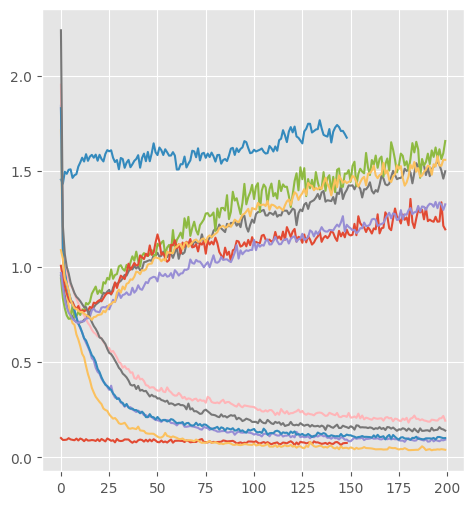

In [ ]:
# Plotting the results for all models including new variants
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Original CNN - Train Loss')
plt.plot(history.history['val_loss'], label='Original CNN - Val Loss')
plt.plot(dilated_cnn_history.history['loss'], label='Dilated CNN - Train Loss')
plt.plot(dilated_cnn_history.history['val_loss'], label='Dilated CNN - Val Loss')
plt.plot(residual_cnn_history.history['loss'], label='Residual CNN - Train Loss')
plt.plot(residual_cnn_history.history['val_loss'], label='Residual CNN - Val Loss')
plt.plot(attention_cnn_history.history['loss'], label='Attention CNN - Train Loss')
plt.plot(attention_cnn_history.history['val_loss'], label='Attention CNN - Val Loss')
plt.plot(inception_cnn_history.history['loss'], label='Inception CNN - Train Loss')
plt.plot(inception_cnn_history.history['val_loss'], label='Inception CNN - Val Loss')
plt.plot(depthwise_separable_cnn_history.history['loss'], label='Depthwise Separable CNN - Train Loss')
plt.plot(depthwise_separable_cnn_history.history['val_loss'], label='Depthwise Separable CNN - Val Loss')
plt.plot(capsule_history.history['loss'], label='Capsule Network - Train Loss')
plt.plot(capsule_history.history['val_loss'], label='Capsule Network - Val Loss')
plt.plot(tcn_history.history['loss'], label='TCN - Train Loss')
plt.plot(tcn_history.history['val_loss'], label='TCN - Val Loss')
plt.plot(multi_head_cnn_history.history['loss'], label='Multi-Head CNN - Train Loss')
plt.plot(multi_head_cnn_history.history['val_loss'], label='Multi-Head CNN - Val Loss')
plt.plot(hybrid_history.history['loss'], label='Hybrid CNN + BiLSTM - Train Loss')
plt.plot(hybrid_history.history['val_loss'], label='Hybrid CNN + BiLSTM - Val Loss')
plt.plot(char_cnn_history.history['loss'], label='Character-level CNN - Train Loss')
plt.plot(char_cnn_history.history['val_loss'], label='Character-level CNN - Val Loss')
plt.plot(cnn_crf_history.history['loss'], label='CNN + CRF - Train Loss')
plt.plot(cnn_crf_history.history['val_loss'], label='CNN + CRF - Val Loss')
plt.plot(self_attention_cnn_history.history['loss'], label='Self-Attention CNN - Train Loss')
plt.plot(self_attention_cnn_history.history['val_loss'], label='Self-Attention CNN - Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Original CNN - Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Original CNN - Val Accuracy')
plt.plot(dilated_cnn_history.history['accuracy'], label='Dilated CNN - Train Accuracy')
plt.plot(dilated_cnn_history.history['val_accuracy'], label='Dilated CNN - Val Accuracy')
plt.plot(residual_cnn_history.history['accuracy'], label='Residual CNN - Train Accuracy')
plt.plot(residual_cnn_history.history['val_accuracy'], label='Residual CNN - Val Accuracy')
plt.plot(attention_cnn_history.history['accuracy'], label='Attention CNN - Train Accuracy')
plt.plot(attention_cnn_history.history['val_accuracy'], label='Attention CNN - Val Accuracy')
plt.plot(inception_cnn_history.history['accuracy'], label='Inception CNN - Train Accuracy')
plt.plot(inception_cnn_history.history['val_accuracy'], label='Inception CNN - Val Accuracy')
plt.plot(depthwise_separable_cnn_history.history['accuracy'], label='Depthwise Separable CNN - Train Accuracy')
plt.plot(depthwise_separable_cnn_history.history['val_accuracy'], label='Depthwise Separable CNN - Val Accuracy')
plt.plot(capsule_history.history['accuracy'], label='Capsule Network - Train Accuracy')
plt.plot(capsule_history.history['val_accuracy'], label='Capsule Network - Val Accuracy')
plt.plot(tcn_history.history['accuracy'], label='TCN - Train Accuracy')
plt.plot(tcn_history.history['val_accuracy'], label='TCN - Val Accuracy')
plt.plot(multi_head_cnn_history.history['accuracy'], label='Multi-Head CNN - Train Accuracy')
plt.plot(multi_head_cnn_history.history['val_accuracy'], label='Multi-Head CNN - Val Accuracy')
plt.plot(hybrid_history.history['accuracy'], label='Hybrid CNN + BiLSTM - Train Accuracy')
plt.plot(hybrid_history.history['val_accuracy'], label='Hybrid CNN + BiLSTM - Val Accuracy')
plt.plot(char_cnn_history.history['accuracy'], label='Character-level CNN - Train Accuracy')
plt.plot(char_cnn_history.history['val_accuracy'], label='Character-level CNN - Val Accuracy')
plt.plot(cnn_crf_history.history['accuracy'], label='CNN + CRF - Train Accuracy')
plt.plot(cnn_crf_history.history['val_accuracy'], label='CNN + CRF - Val Accuracy')
plt.plot(self_attention_cnn_history.history['accuracy'], label='Self-Attention CNN - Train Accuracy')
plt.plot(self_attention_cnn_history.history['val_accuracy'], label='Self-Attention CNN - Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Variasi LSTM

### Basic LSTM

In [ ]:
# Define LSTM model
lstm_model = Sequential([
    InputLayer(input_shape=(max_len,)),
    Embedding(input_dim=num_words, output_dim=128, input_length=max_len),
    LSTM(units=128, return_sequences=True, dropout=0.5),
    TimeDistributed(Dense(num_tags, activation='softmax'))
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
lstm_history = lstm_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2)

# Evaluate LSTM model
lstm_eval = lstm_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"LSTM Model - Loss: {lstm_eval[0]}, Accuracy: {lstm_eval[1]}")

Epoch 1/200
23/23 [==============================] - 6s 122ms/step - loss: 1.6534 - accuracy: 0.6299 - val_loss: 1.0143 - val_accuracy: 0.6592
Epoch 2/200
23/23 [==============================] - 3s 142ms/step - loss: 1.0253 - accuracy: 0.6673 - val_loss: 0.9407 - val_accuracy: 0.6654
Epoch 3/200
23/23 [==============================] - 3s 146ms/step - loss: 0.9186 - accuracy: 0.6640 - val_loss: 0.8754 - val_accuracy: 0.6974
Epoch 4/200
23/23 [==============================] - 2s 95ms/step - loss: 0.8499 - accuracy: 0.7022 - val_loss: 0.8053 - val_accuracy: 0.7694
Epoch 5/200
23/23 [==============================] - 3s 117ms/step - loss: 0.7821 - accuracy: 0.7355 - val_loss: 0.7684 - val_accuracy: 0.7750
Epoch 6/200
23/23 [==============================] - 3s 125ms/step - loss: 0.7172 - accuracy: 0.7499 - val_loss: 0.7593 - val_accuracy: 0.7684
Epoch 7/200
23/23 [==============================] - 3s 123ms/step - loss: 0.6751 - accuracy: 0.7642 - val_loss: 0.7837 - val_accuracy: 0.7416


### Bi-LSTM

In [ ]:
# Define BiLSTM model
bilstm_model = Sequential([
    InputLayer(input_shape=(max_len,)),
    Embedding(input_dim=num_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.5)),
    TimeDistributed(Dense(num_tags, activation='softmax'))
])

# Compile the model
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
bilstm_history = bilstm_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2)

# Evaluate BiLSTM model
bilstm_eval = bilstm_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"BiLSTM Model - Loss: {bilstm_eval[0]}, Accuracy: {bilstm_eval[1]}")

Epoch 1/200
23/23 [==============================] - 10s 207ms/step - loss: 1.5526 - accuracy: 0.6349 - val_loss: 0.9523 - val_accuracy: 0.7562
Epoch 2/200
23/23 [==============================] - 7s 326ms/step - loss: 0.8694 - accuracy: 0.7433 - val_loss: 0.7523 - val_accuracy: 0.7801
Epoch 3/200
23/23 [==============================] - 5s 207ms/step - loss: 0.7767 - accuracy: 0.7492 - val_loss: 0.7084 - val_accuracy: 0.7808
Epoch 4/200
23/23 [==============================] - 4s 183ms/step - loss: 0.7416 - accuracy: 0.7494 - val_loss: 0.6928 - val_accuracy: 0.7823
Epoch 5/200
23/23 [==============================] - 6s 247ms/step - loss: 0.7085 - accuracy: 0.7562 - val_loss: 0.6898 - val_accuracy: 0.7821
Epoch 6/200
23/23 [==============================] - 4s 164ms/step - loss: 0.6676 - accuracy: 0.7808 - val_loss: 0.6738 - val_accuracy: 0.7816
Epoch 7/200
23/23 [==============================] - 4s 164ms/step - loss: 0.6093 - accuracy: 0.7956 - val_loss: 0.6823 - val_accuracy: 0.779

### LSTM CRF TERLUPAKAN

### LSTM ATTENTION

In [ ]:
from tensorflow.keras.layers import Attention

# Define LSTM + Attention model
inputs = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(inputs)
lstm_out = LSTM(units=128, return_sequences=True, dropout=0.5)(model)

# Apply Attention
attention = Attention()([lstm_out, lstm_out])
attention_output = Dense(num_tags, activation='softmax')(attention)

# Define the model
lstm_attention_model = Model(inputs, attention_output)

# Compile the model
lstm_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
lstm_attention_history = lstm_attention_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2)

# Evaluate LSTM + Attention model
lstm_attention_eval = lstm_attention_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"LSTM + Attention Model - Loss: {lstm_attention_eval[0]}, Accuracy: {lstm_attention_eval[1]}")

Epoch 1/200
23/23 [==============================] - 5s 130ms/step - loss: 1.6864 - accuracy: 0.6265 - val_loss: 1.1218 - val_accuracy: 0.6571
Epoch 2/200
23/23 [==============================] - 2s 98ms/step - loss: 1.0437 - accuracy: 0.6544 - val_loss: 0.9859 - val_accuracy: 0.6728
Epoch 3/200
23/23 [==============================] - 4s 155ms/step - loss: 0.9569 - accuracy: 0.6581 - val_loss: 0.9362 - val_accuracy: 0.6643
Epoch 4/200
23/23 [==============================] - 3s 140ms/step - loss: 0.9026 - accuracy: 0.6652 - val_loss: 0.8970 - val_accuracy: 0.6840
Epoch 5/200
23/23 [==============================] - 2s 108ms/step - loss: 0.8492 - accuracy: 0.6815 - val_loss: 0.8414 - val_accuracy: 0.7306
Epoch 6/200
23/23 [==============================] - 2s 105ms/step - loss: 0.7839 - accuracy: 0.7115 - val_loss: 0.7700 - val_accuracy: 0.7623
Epoch 7/200
23/23 [==============================] - 2s 106ms/step - loss: 0.7068 - accuracy: 0.7509 - val_loss: 0.7514 - val_accuracy: 0.7484


### Bi-LSTM ATTENTION

In [ ]:
# Define BiLSTM + Attention model
inputs = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=128, input_length=max_len)(inputs)
bilstm_out = Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.5))(model)

# Apply Attention
attention = Attention()([bilstm_out, bilstm_out])
attention_output = Dense(num_tags, activation='softmax')(attention)

# Define the model
bilstm_attention_model = Model(inputs, attention_output)

# Compile the model
bilstm_attention_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
bilstm_attention_history = bilstm_attention_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2)

# Evaluate BiLSTM + Attention model
bilstm_attention_eval = bilstm_attention_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"BiLSTM + Attention Model - Loss: {bilstm_attention_eval[0]}, Accuracy: {bilstm_attention_eval[1]}")

Epoch 1/200
23/23 [==============================] - 11s 304ms/step - loss: 1.6048 - accuracy: 0.6264 - val_loss: 0.8972 - val_accuracy: 0.6569
Epoch 2/200
23/23 [==============================] - 4s 166ms/step - loss: 0.8423 - accuracy: 0.7271 - val_loss: 0.7421 - val_accuracy: 0.7791
Epoch 3/200
23/23 [==============================] - 4s 171ms/step - loss: 0.7559 - accuracy: 0.7493 - val_loss: 0.7220 - val_accuracy: 0.7704
Epoch 4/200
23/23 [==============================] - 6s 262ms/step - loss: 0.7426 - accuracy: 0.7500 - val_loss: 0.6944 - val_accuracy: 0.7843
Epoch 5/200
23/23 [==============================] - 4s 170ms/step - loss: 0.7235 - accuracy: 0.7534 - val_loss: 0.6850 - val_accuracy: 0.7844
Epoch 6/200
23/23 [==============================] - 5s 236ms/step - loss: 0.7107 - accuracy: 0.7539 - val_loss: 0.6824 - val_accuracy: 0.7845
Epoch 7/200
23/23 [==============================] - 7s 288ms/step - loss: 0.7032 - accuracy: 0.7585 - val_loss: 0.6837 - val_accuracy: 0.782

In [ ]:
# Plotting the results for all LSTM models
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='LSTM - Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM - Val Loss')
plt.plot(bilstm_history.history['loss'], label='BiLSTM - Train Loss')
plt.plot(bilstm_history.history['val_loss'], label='BiLSTM - Val Loss')
plt.plot(lstm_crf_history.history['loss'], label='LSTM + CRF - Train Loss')
plt.plot(lstm_crf_history.history['val_loss'], label='LSTM + CRF - Val Loss')
plt.plot(bilstm_crf_history.history['loss'], label='BiLSTM + CRF - Train Loss')
plt.plot(bilstm_crf_history.history['val_loss'], label='BiLSTM + CRF - Val Loss')
plt.plot(lstm_attention_history.history['loss'], label='LSTM + Attention - Train Loss')
plt.plot(lstm_attention_history.history['val_loss'], label='LSTM + Attention - Val Loss')
plt.plot(bilstm_attention_history.history['loss'], label='BiLSTM + Attention - Train Loss')
plt.plot(bilstm_attention_history.history['val_loss'], label='BiLSTM + Attention - Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['accuracy'], label='LSTM - Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM - Val Accuracy')
plt.plot(bilstm_history.history['accuracy'], label='BiLSTM - Train Accuracy')
plt.plot(bilstm_history.history['val_accuracy'], label='BiLSTM - Val Accuracy')
plt.plot(lstm_crf_history.history['accuracy'], label='LSTM + CRF - Train Accuracy')
plt.plot(lstm_crf_history.history['val_accuracy'], label='LSTM + CRF - Val Accuracy')
plt.plot(bilstm_crf_history.history['accuracy'], label='BiLSTM + CRF - Train Accuracy')
plt.plot(bilstm_crf_history.history['val_accuracy'], label='BiLSTM + CRF - Val Accuracy')
plt.plot(lstm_attention_history.history['accuracy'], label='LSTM + Attention - Train Accuracy')
plt.plot(lstm_attention_history.history['val_accuracy'], label='LSTM + Attention - Val Accuracy')
plt.plot(bilstm_attention_history.history['accuracy'], label='BiLSTM + Attention - Train Accuracy')
plt.plot(bilstm_attention_history.history['

SyntaxError: unterminated string literal (detected at line 34) (<ipython-input-33-a93d5038a094>, line 34)

In [ ]:
# Plotting the results for all LSTM models
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='LSTM - Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM - Val Loss')
plt.plot(bilstm_history.history['loss'], label='BiLSTM - Train Loss')
plt.plot(bilstm_history.history['val_loss'], label='BiLSTM - Val Loss')
plt.plot(lstm_crf_history.history['loss'], label='LSTM + CRF - Train Loss')
plt.plot(lstm_crf_history.history['val_loss'], label='LSTM + CRF - Val Loss')
plt.plot(bilstm_crf_history.history['loss'], label='BiLSTM + CRF - Train Loss')
plt.plot(bilstm_crf_history.history['val_loss'], label='BiLSTM + CRF - Val Loss')
plt.plot(lstm_attention_history.history['loss'], label='LSTM + Attention - Train Loss')
plt.plot(lstm_attention_history.history['val_loss'], label='LSTM + Attention - Val Loss')
plt.plot(bilstm_attention_history.history['loss'], label='BiLSTM + Attention - Train Loss')
plt.plot(bilstm_attention_history.history['val_loss'], label='BiLSTM + Attention - Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['accuracy'], label='LSTM - Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM - Val Accuracy')
plt.plot(bilstm_history.history['accuracy'], label='BiLSTM - Train Accuracy')
plt.plot(bilstm_history.history['val_accuracy'], label='BiLSTM - Val Accuracy')
plt.plot(lstm_crf_history.history['accuracy'], label='LSTM + CRF - Train Accuracy')
plt.plot(lstm_crf_history.history['val_accuracy'], label='LSTM + CRF - Val Accuracy')
plt.plot(bilstm_crf_history.history['accuracy'], label='BiLSTM + CRF - Train Accuracy')
plt.plot(bilstm_crf_history.history['val_accuracy'], label='BiLSTM + CRF - Val Accuracy')
plt.plot(lstm_attention_history.history['accuracy'], label='LSTM + Attention - Train Accuracy')
plt.plot(lstm_attention_history.history['val_accuracy'], label='LSTM + Attention - Val Accuracy')
plt.plot(bilstm_attention_history.history['accuracy'], label='BiLSTM + Attention - Train Accuracy')
plt.plot(bilstm_attention_history.history['val_accuracy'], label='BiLSTM + Attention - Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Variasi RNN

In [ ]:
# Define Simple RNN model
rnn_model = Sequential([
    InputLayer(input_shape=(max_len,)),
    Embedding(input_dim=num_words, output_dim=128, input_length=max_len),
    SimpleRNN(units=128, return_sequences=True, dropout=0.5),
    TimeDistributed(Dense(num_tags, activation='softmax'))
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
rnn_history = rnn_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2)

# Evaluate Simple RNN model
rnn_eval = rnn_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Simple RNN Model - Loss: {rnn_eval[0]}, Accuracy: {rnn_eval[1]}")

In [ ]:
# Define GRU model
gru_model = Sequential([
    InputLayer(input_shape=(max_len,)),
    Embedding(input_dim=num_words, output_dim=128, input_length=max_len),
    GRU(units=128, return_sequences=True, dropout=0.5),
    TimeDistributed(Dense(num_tags, activation='softmax'))
])

# Compile the model
gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
gru_history = gru_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2)

# Evaluate GRU model
gru_eval = gru_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"GRU Model - Loss: {gru_eval[0]}, Accuracy: {gru_eval[1]}")

In [ ]:
# Define LSTM model
lstm_model = Sequential([
    InputLayer(input_shape=(max_len,)),
    Embedding(input_dim=num_words, output_dim=128, input_length=max_len),
    LSTM(units=128, return_sequences=True, dropout=0.5),
    TimeDistributed(Dense(num_tags, activation='softmax'))
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
lstm_history = lstm_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2)

# Evaluate LSTM model
lstm_eval = lstm_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"LSTM Model - Loss: {lstm_eval[0]}, Accuracy: {lstm_eval[1]}")

In [ ]:
# Define Bidirectional Simple RNN model
birnn_model = Sequential([
    InputLayer(input_shape=(max_len,)),
    Embedding(input_dim=num_words, output_dim=128, input_length=max_len),
    Bidirectional(SimpleRNN(units=128, return_sequences=True, dropout=0.5)),
    TimeDistributed(Dense(num_tags, activation='softmax'))
])

# Compile the model
birnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
birnn_history = birnn_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2)

# Evaluate Bidirectional Simple RNN model
birnn_eval = birnn_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Bidirectional Simple RNN Model - Loss: {birnn_eval[0]}, Accuracy: {birnn_eval[1]}")

In [ ]:
# Define Bidirectional Simple RNN model
birnn_model = Sequential([
    InputLayer(input_shape=(max_len,)),
    Embedding(input_dim=num_words, output_dim=128, input_length=max_len),
    Bidirectional(SimpleRNN(units=128, return_sequences=True, dropout=0.5)),
    TimeDistributed(Dense(num_tags, activation='softmax'))
])

# Compile the model
birnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
birnn_history = birnn_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2)

# Evaluate Bidirectional Simple RNN model
birnn_eval = birnn_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Bidirectional Simple RNN Model - Loss: {birnn_eval[0]}, Accuracy: {birnn_eval[1]}")

In [ ]:
# Define Bidirectional GRU model
bigru_model = Sequential([
    InputLayer(input_shape=(max_len,)),
    Embedding(input_dim=num_words, output_dim=128, input_length=max_len),
    Bidirectional(GRU(units=128, return_sequences=True, dropout=0.5)),
    TimeDistributed(Dense(num_tags, activation='softmax'))
])

# Compile the model
bigru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
bigru_history = bigru_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2)

# Evaluate Bidirectional GRU model
bigru_eval = bigru_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Bidirectional GRU Model - Loss: {bigru_eval[0]}, Accuracy: {bigru_eval[1]}")

In [ ]:
# Define Bidirectional GRU model
bigru_model = Sequential([
    InputLayer(input_shape=(max_len,)),
    Embedding(input_dim=num_words, output_dim=128, input_length=max_len),
    Bidirectional(GRU(units=128, return_sequences=True, dropout=0.5)),
    TimeDistributed(Dense(num_tags, activation='softmax'))
])

# Compile the model
bigru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
bigru_history = bigru_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2)

# Evaluate Bidirectional GRU model
bigru_eval = bigru_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Bidirectional GRU Model - Loss: {bigru_eval[0]}, Accuracy: {bigru_eval[1]}")

In [ ]:
# Define Bidirectional LSTM model
bilstm_model = Sequential([
    InputLayer(input_shape=(max_len,)),
    Embedding(input_dim=num_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.5)),
    TimeDistributed(Dense(num_tags, activation='softmax'))
])

# Compile the model
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
bilstm_history = bilstm_model.fit(x_train, np.array(y_train), epochs=200, batch_size=32, validation_split=0.2)

# Evaluate Bidirectional LSTM model
bilstm_eval = bilstm_model.evaluate(x_test, np.array(y_test), verbose=0)
print(f"Bidirectional LSTM Model - Loss: {bilstm_eval[0]}, Accuracy: {bilstm_eval[1]}")

In [ ]:
# Plotting the results for all RNN models
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['loss'], label='Simple RNN - Train Loss')
plt.plot(rnn_history.history['val_loss'], label='Simple RNN - Val Loss')
plt.plot(gru_history.history['loss'], label='GRU - Train Loss')
plt.plot(gru_history.history['val_loss'], label='GRU - Val Loss')
plt.plot(lstm_history.history['loss'], label='LSTM - Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM - Val Loss')
plt.plot(birnn_history.history['loss'], label='Bidirectional Simple RNN - Train Loss')
plt.plot(birnn_history.history['val_loss'], label='Bidirectional Simple RNN - Val Loss')
plt.plot(bigru_history.history['loss'], label='Bidirectional GRU - Train Loss')
plt.plot(bigru_history.history['val_loss'], label='Bidirectional GRU - Val Loss')
plt.plot(bilstm_history.history['loss'], label='Bidirectional LSTM - Train Loss')
plt.plot(bilstm_history.history['val_loss'], label='Bidirectional LSTM - Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['accuracy'], label='Simple RNN - Train Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Simple RNN - Val Accuracy')
plt.plot(gru_history.history['accuracy'], label='GRU - Train Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='GRU - Val Accuracy')
plt.plot(lstm_history.history['accuracy'], label='LSTM - Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM - Val Accuracy')
plt.plot(birnn_history.history['accuracy'], label='Bidirectional Simple RNN - Train Accuracy')
plt.plot(birnn_history.history['val_accuracy'], label='Bidirectional Simple RNN - Val Accuracy')
plt.plot(bigru_history.history['accuracy'], label='Bidirectional GRU - Train Accuracy')
plt.plot(bigru_history.history['val_accuracy'], label='Bidirectional GRU - Val Accuracy')
plt.plot(bilstm_history.history['accuracy'], label='Bidirectional LSTM - Train Accuracy')
plt.plot(bilstm_history.history['val_accuracy'], label='Bidirectional LSTM - Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()